In [539]:
! pip install --upgrade pip
! pip install pandas
! pip install tabulate
! pip install matplotlib
! pip install openpyxl
warnings.filterwarnings('ignore')

1049065.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/ef/7d/500c9ad20238fcfcb4cb9243eede163594d7020ce87bd9610c9e02771876/pip-24.3.1-py3-none-any.whl.metadata
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


1049073.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


1049079.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


1049085.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


1049091.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


kruskal 的說明: https://drfishstats.com/inferential-stats/statistical-tests/nonparametric-tests/kruskal-wallis-test/ 

In [580]:
"""
Use Shapirpo to test the normality, if normal, use anova, if not normal, use Kruskal-Wallis to test the significant diffenece of mean
"""
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy.stats import kruskal


def test_group_mean(df:pd.DataFrame, dim:str, value_col:str, p_value_=0.05, only_significant=True):
    
    # Get unique groups dynamically
    unique_groups = df[dim].unique()

    # Group the data dynamically
    group_data = [df[df[dim] == group][value_col].values for group in unique_groups]

    # test the normality for all group data
    _normality = True
    _non_parametric = False
    for grp_data in group_data:
        _, p = shapiro(grp_data)
        if p<=p_value_: _normality = False
    # Perform one-way ANOVA
    if _normality:
        stat, p_value = f_oneway(*group_data)
        #print(f"ANOVA Statistic: {stat:.4f}, P-Value: {p_value:.4f}")
    else:  
        _non_parametric = True
        stat, p_value = kruskal(*group_data)
        # print(f"Kruskal Statistic: {stat:.4f}, P-Value: {p_value:.4f}")

    results_ = [] 
    results = []   
    if p_value <= p_value_:
        results_.append({
            "Anova": _normality,
            "Kruskal":_non_parametric,
            "Dimension": dim,
            "val_col": value_col,
            "Group": unique_groups,
            "Stat": stat,
            "P-Value": p_value
        })
        #print(f"Given {dim} found {grp} has group mean {grp_values.mean()} is greater than the total mean {total_mean} on col {value_col}, ")
    results.append({
            "Anova": _normality,
            "Kruskal":_non_parametric,
            "Dimension": dim,
            "val_col": value_col,
            "Group": unique_groups,
            "Stat": stat,
            "P-Value": p_value
    })
    
    if only_significant: results = results_
    return results

def test_all_grp_means(df,categorical_cols, numeric_cols):
    categorical_columns = categorical_cols
    numeric_columns = numeric_cols
    total_result = []
    for _col in categorical_columns:
        for col in numeric_columns:
            results1 = test_group_mean(df, _col, col)
            if results1 == []: continue
            total_result.append(results1)

    # Convert results to a DataFrame and print

    return pd.DataFrame(total_result)
    


In [660]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

categories = {
    "V(不及動詞)": ["V","AUX,V","AUX1,AUX2,V","VV","AUX,VV"],
    "VE(不及動詞+延伸受事)": ["VE","AUX,VE","AUX1,AUX2,VE","VVE","AUX,VVE"],
    "VES(不及動+延伸受事+主詞)": ["VES","AUX,VES"],
    "VS(不及動詞+主詞)": ["VS","AUX,VS","AUX1AUX2,VS","VSE","VVS","AUX,VVS"],
    "VP(及物動詞+受事者)": ["VP","VPc",	"AUX,VPc","VVP","AUX,VVP","VAP","VAPc","AUX,VAP","VPA","AUX1,AUX2,VPA","AUX,PAV","AUX,PVA"],
    "AV(主詞+及物動)":	["AUX,AV","AUX,AVE","AVP","AUX,AVP"],
    "NEG V(否定+不及物動詞)":["NEG,V","NEG,VV","NEG,VE","NEG,VVE"],
    "NEG VP(否定+及物動+受詞)":	["NEG,VAP","NEG,VP","NEG,VPc"],
    "NEG AV(否定+主+及物動詞)":	["NEG,AV","NGA,AVV","NEG,AVP"],
    "SV(主詞+不及物動詞)":["SV","SVE"]
}
#iudata = pd.read_csv('iu_ataya_hsinchu.csv')
def get_df():
    iudata = pd.read_excel('./source_data/言談語料IUs分析_20250101.xlsx','地區統計-1')
    df_ = iudata.fillna(0)
    df_ = df_.drop(columns=["編號"])
    df_ = df_.drop(columns=["年齡"])
    df_ = df_.drop(columns=["Ius數量小計"])
    df_.to_csv('iu_ataya_hsinchu_de01.csv')
    #pd.drop(df_)
    #df = pd.read_csv('iu_ataya_hsinchu_de01.csv')
    df = df_.copy()
    return df

def get_category_sum_df():
    df = get_df()
    # Validate all category's ius are in grouped numeric_columns
    for category, items in categories.items():
        for item in items:
            if item not in numeric_columns: 
                print( f"category {category}'s {item} not in numeric_columns")

    # Generate new columns by summing columns that start with each prefix
    
    cat_df = pd.DataFrame.empty
    for category,items in categories.items():
        df[category] = df[items].sum(axis=1)
    return df

df = get_df()
df_w_merged_items = get_category_sum_df()
categorical_columns = ["區域", "學歷", "從業", "年齡區間"]
merged_item_columns = [col for col in df_w_merged_items.columns if col.endswith(')')]
df_only_merged_items = df_w_merged_items[categorical_columns+merged_item_columns]

numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns
# Group sum
grouped = df.groupby(categorical_columns)[numeric_columns].sum()
grouped = grouped.astype(int)
grouped.to_csv("grouped_by_AEJY.csv")

merged_items_grouped = df_only_merged_items.groupby(categorical_columns)[merged_item_columns ].sum()
merged_items_grouped = merged_items_grouped.astype(int)
merged_items_grouped.to_csv("merged_items_grouped_by_AEJY.csv")

In [666]:
import numpy as np

def group_df_by_categ(df:pd.DataFrame, categorical_columns, transpose=True, percetage_by_grantotal=True):
    numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns

    # Group sum
    grouped = df.groupby(categorical_columns)[numeric_columns].sum()

    grant_total = grouped.sum(axis=0).values.sum()
    if percetage_by_grantotal:
        grant_total_percentage = grouped.div(grant_total, axis=0) * 100
    # Calculate percentage within each group
    grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Filter out rows where all numeric columns are NaN
    grouped = grouped.dropna(how='all')
    grouped_percentage = grouped_percentage.dropna(how='all')
    if percetage_by_grantotal: grant_total_percentage = grant_total_percentage.dropna(how='all')


    # Filter out rows where all numeric columns are zero
    grouped = grouped[(grouped != 0).any(axis=1)]
    grouped_percentage = grouped_percentage[(grouped_percentage != 0).any(axis=1)]
    if percetage_by_grantotal: grant_total_percentage = grant_total_percentage[(grant_total_percentage != 0).any(axis=1)]
    # Format grouped values as integers
    grouped = grouped.astype(int)

    # Format grouped percentages to three decimal places (ceiling to 10^-3)
    grouped_percentage = grouped_percentage.applymap(lambda x: np.ceil(x * 100) / 100)
    if percetage_by_grantotal: grant_total_percentage = grant_total_percentage.applymap(lambda x: np.ceil(x * 100) / 100)

    # Merge sums and percentages for each numeric column
    merged_grouped = grouped.copy()
    for col in grouped.columns:
        if percetage_by_grantotal:
            merged_grouped[col] = (
                grouped[col].astype(int).astype(str) + 
                " (" +
                grouped_percentage[col].round(3).astype(str) + 
                "%)" +
                " (" +
                grant_total_percentage[col].round(3).astype(str) + 
                "%)"
            )
        else:            
            merged_grouped[col] = (
                grouped[col].astype(int).astype(str) + 
                " (" +
                grouped_percentage[col].round(3).astype(str) + 
                "%)"
            )

    # Convert to Markdown table
    if transpose: 
        result_dataset = merged_grouped.T.reset_index()
        merged_grouped_markdown = result_dataset.to_markdown(index=False, tablefmt="pipe")
    else: 
        result_dataset = merged_grouped.reset_index()
        merged_grouped_markdown = merged_grouped.reset_index().to_markdown(index=False, tablefmt="pipe")

    return merged_grouped_markdown, result_dataset


Merged Group Result (Sum and Percentage for Each Numeric Column):


In [672]:
# 將每一個 iu item 群組後，算出該組內(如學歷為高中)在該項目 (如 V,'AUX,V' 等)所佔的比例與該組內佔整體(所有 ius )的比例
# Group by all categorical columns

def group_by_(data:pd.DataFrame, categorical_cols, transpose, filename:str):
    merged_grouped_markdown, result_dataset = group_df_by_categ(data, categorical_cols, transpose=False)
    print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
    print(merged_grouped_markdown)
    result_dataset.to_csv(filename)

categorical_columns = ["區域", "學歷", "從業", "年齡區間"]
group_by_(df, categorical_columns, transpose=False, filename="df_by_區域_學歷_從業_年齡區間.csv")
group_by_(df, categorical_columns, transpose=True, filename="df_by_區域_學歷_從業_年齡區間_T.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=False, filename="df_only_merged_items_by_區域_學歷_從業_年齡區間.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=True, filename="df_only_merged_items_by_區域_學歷_從業_年齡區間_T.csv")

# Group by 區域 categorical columns
categorical_columns = ["區域"]
group_by_(df, categorical_columns, transpose=False, filename="df_by_區域.csv")
group_by_(df, categorical_columns, transpose=True, filename="df_by_區域_T.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=False, filename="df_only_merged_items_by_區域csv")
group_by_(df_only_merged_items, categorical_columns, transpose=True, filename="df_only_merged_items_by_區域_T.csv")

# Group by 學歷 categorical columns
group_by_(df, categorical_columns, transpose=False, filename="df_by_學歷.csv")
group_by_(df, categorical_columns, transpose=True, filename="df_by_學歷_T.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=False, filename="df_only_merged_items_by_學歷.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=True, filename="df_only_merged_items_by_學歷_T.csv")

# Group by 從業 categorical columns
categorical_columns = ["從業"]
group_by_(df, categorical_columns, transpose=False, filename="df_by_從業.csv")
group_by_(df, categorical_columns, transpose=True, filename="df_by_從業_T.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=False, filename="df_only_merged_items_by_從業.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=True, filename="df_only_merged_items_by_從業_T.csv")

# Group by 年齡區間 categorical columns
categorical_columns = ["年齡區間"]
categorical_columns = ["年齡區間"]
group_by_(df, categorical_columns, transpose=False, filename="df_by_年齡區間.csv")
group_by_(df, categorical_columns, transpose=True, filename="df_by_年齡區間_T.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=False, filename="df_only_merged_items_by_年齡區間.csv")
group_by_(df_only_merged_items, categorical_columns, transpose=True, filename="df_only_merged_items_by_年齡區間_T.csv")


Merged Group Result (Sum and Percentage for Each Numeric Column):
| 區域     | 學歷   | 從業   | 年齡區間   | V                  | AUX,V               | AUX1,AUX2,V       | VV                 | AUX,VV             | VE                 | AUX,VE              | AUX1,AUX2,VE      | VVE               | AUX,VVE            | VES               | AUX,VES            | VS                  | AUX,VS             | AUX1AUX2,VS       | VSE               | VVS                | AUX,VVS           | VP                | VPc               | AUX,VPc           | VVP               | AUX,VVP           | VAP                | VAPc              | AUX,VAP           | VPA               | AUX1,AUX2,VPA     | AUX,PAV           | AUX,PVA           | AUX,AV            | AUX,AVE            | AVP               | AUX,AVP            | NEG,V              | NEG,VV            | NEG,VE            | NEG,VVE           | NEG,VAP           | NEG,VP            | NEG,VPc           | NEG,AV            | NGA,AVV           | NEG,AVP           | SV

In [665]:
# 
# Group by categorical columns
categorical_columns = ["區域", "學歷", "從業", "年齡區間"]
merged_grouped_markdown = group_df_by_categ(df_only_merged_items, categorical_columns, transpose=False)
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)
# Group by categorical columns
categorical_columns = ["區域", "學歷", "從業", "年齡區間"]
merged_grouped_markdown = group_df_by_categ(df_only_merged_items, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)
# Group by categorical columns
categorical_columns = ["區域"]
merged_grouped_markdown = group_df_by_categ(df_only_merged_items, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)

categorical_columns = ["學歷"]
merged_grouped_markdown = group_df_by_categ(df_only_merged_items, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)

categorical_columns = ["從業"]
merged_grouped_markdown = group_df_by_categ(df_only_merged_items, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)

categorical_columns = ["年齡區間"]
merged_grouped_markdown = group_df_by_categ(df_only_merged_items, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)

Merged Group Result (Sum and Percentage for Each Numeric Column):
| 區域     | 學歷   | 從業   | 年齡區間   | V(不及動詞)         | VE(不及動詞+延伸受事)   | VES(不及動+延伸受事+主詞)   | VS(不及動詞+主詞)   | VP(及物動詞+受事者)   | AV(主詞+及物動)    | NEG V(否定+不及物動詞)   | NEG VP(否定+及物動+受詞)   | NEG AV(否定+主+及物動詞)   | SV(主詞+不及物動詞)   |
|:---------|:-------|:-------|:-----------|:--------------------|:------------------------|:----------------------------|:--------------------|:----------------------|:-------------------|:-------------------------|:---------------------------|:---------------------------|:----------------------|
| 五峰鄉   | 國中   | 工     | 60~69      | 5 (20.84%) (0.63%)  | 6 (25.0%) (0.76%)       | 1 (4.17%) (0.13%)           | 9 (37.5%) (1.14%)   | 2 (8.34%) (0.26%)     | 1 (4.17%) (0.13%)  | 0 (0.0%) (0.0%)          | 0 (0.0%) (0.0%)            | 0 (0.0%) (0.0%)            | 0 (0.0%) (0.0%)       |
| 五峰鄉   | 國中   | 農     | 60~69      | 5 (26.32%) (0.63%)  | 4 (21.06%) (0.51%)      | 0 (0.0%) (0.0%)             | 6 (31.5

In [657]:
df_only_merged_items 
 
#df_w_merged_item[categorical_columns+merged_item_columns]

,區域,學歷,從業,年齡區間,V(不及動詞),VE(不及動詞+延伸受事),VES(不及動+延伸受事+主詞),VS(不及動詞+主詞),VP(及物動詞+受事者),AV(主詞+及物動),NEG V(否定+不及物動詞),NEG VP(否定+及物動+受詞),NEG AV(否定+主+及物動詞),SV(主詞+不及物動詞)
0,尖石前山,國中,家管,60~69,2.0,8.0,0.0,3.0,1.0,2.0,1.0,0.0,0.0,0.0
1,尖石前山,大專,公教,50~59,1.0,2.0,0.0,6.0,3.0,1.0,1.0,1.0,2.0,1.0
2,尖石前山,大專,公教,40~49,0.0,4.0,0.0,3.0,9.0,1.0,0.0,1.0,2.0,1.0
3,尖石前山,國中,家管,70~79,0.0,8.0,0.0,6.0,3.0,1.0,0.0,0.0,0.0,0.0
4,尖石前山,國中,家管,70~79,4.0,6.0,1.0,6.0,3.0,1.0,0.0,1.0,0.0,0.0
5,尖石前山,高中,家管,50~59,6.0,5.0,0.0,5.0,4.0,2.0,0.0,0.0,0.0,1.0
6,尖石前山,大專,公教,50~59,3.0,2.0,2.0,3.0,8.0,2.0,0.0,0.0,2.0,0.0
7,尖石前山,高中,家管,40~49,2.0,2.0,3.0,2.0,4.0,1.0,4.0,3.0,0.0,0.0
8,尖石前山,國中,家管,70~79,8.0,6.0,2.0,6.0,6.0,6.0,0.0,0.0,2.0,0.0
9,尖石前山,國中,家管,70~79,8.0,5.0,0.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0


In [584]:
import numpy as np

def boxplot_(df:pd.DataFrame, dim, ius):    
    # Convert 'VAP' to numeric, ignoring non-numeric entries
    df[ius] = pd.to_numeric(df[ius], errors="coerce")

    # Group by '學歷' and get data for each subgroup
    subgroups = df.groupby(dim)[ius].apply(list)

    # Add a 'Total Population' entry to the subgroups
    subgroups["pop"] = df[ius].dropna().tolist()
    subgroups["pop"]
    # Calculate mean for each group
    means = [np.nanmean(group) for group in subgroups.values]
    # Plot boxplots
    # Plot boxplots
    plt.figure(figsize=(10, 6))
    box = plt.boxplot(
        subgroups.values,
        labels=subgroups.index,
        patch_artist=True,
        showmeans=False,  # Disable the default mean marker in Matplotlib
    )

    # Add mean markers manually
    for i, mean in enumerate(means):
        plt.scatter(
            i + 1,  # X-coordinate (boxplot index is 1-based)
            mean,   # Mean value
            color="red",
            marker="o",
            label="Mean" if i == 0 else "",  # Add legend only once
        )


    # Customize the plot
    plt.title(f"Boxplots of {ius} by {dim} and Total Population", fontsize=14)
    plt.ylabel(f"{ius}", fontsize=12)
    plt.xlabel(f"Groups ({dim} + 總體)", fontsize=12)
    plt.legend(loc="upper right")
    # Show the plot
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


In [591]:
# Validate all category's ius are in grouped numeric_columns
for category, items in categories.items():
    for item in items:
        if item not in numeric_columns: 
            print( f"category {category}'s {item} not in numeric_columns")

# Generate new columns by summing columns that start with each prefix
for category,items in categories.items():
    df[category] = df[items].sum(axis=1)
    #print(df[category])

df.to_csv("iu_ataya_hsinchu_with_category.csv")
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns
print(numeric_columns)
result2 = test_all_grp_means(df, categorical_columns, numeric_columns) 
result2.to_csv("grp_mean_test_.csv")
result2

Index(['V', 'AUX,V', 'AUX1,AUX2,V', 'VV', 'AUX,VV', 'VE', 'AUX,VE',
       'AUX1,AUX2,VE', 'VVE', 'AUX,VVE', 'VES', 'AUX,VES', 'VS', 'AUX,VS',
       'AUX1AUX2,VS', 'VSE', 'VVS', 'AUX,VVS', 'VP', 'VPc', 'AUX,VPc', 'VVP',
       'AUX,VVP', 'VAP', 'VAPc', 'AUX,VAP', 'VPA', 'AUX1,AUX2,VPA', 'AUX,PAV',
       'AUX,PVA', 'AUX,AV', 'AUX,AVE', 'AVP', 'AUX,AVP', 'NEG,V', 'NEG,VV',
       'NEG,VE', 'NEG,VVE', 'NEG,VAP', 'NEG,VP', 'NEG,VPc', 'NEG,AV',
       'NGA,AVV', 'NEG,AVP', 'SV', 'SVE', 'V(不及動詞)', 'VE(不及動詞+延伸受事)',
       'VES(不及動+延伸受事+主詞)', 'VS(不及動詞+主詞)', 'VP(及物動詞+受事者)', 'AV(主詞+及物動)',
       'NEG V(否定+不及物動詞)', 'NEG VP(否定+及物動+受詞)', 'NEG AV(否定+主+及物動詞)',
       'SV(主詞+不及物動詞)'],
      dtype='object')


,0
0,"{'Anova': False, 'Kruskal': True, 'Dimension':..."
1,"{'Anova': True, 'Kruskal': False, 'Dimension':..."
2,"{'Anova': True, 'Kruskal': False, 'Dimension':..."
3,"{'Anova': False, 'Kruskal': True, 'Dimension':..."
4,"{'Anova': False, 'Kruskal': True, 'Dimension':..."
5,"{'Anova': False, 'Kruskal': True, 'Dimension':..."
6,"{'Anova': False, 'Kruskal': True, 'Dimension':..."
7,"{'Anova': False, 'Kruskal': True, 'Dimension':..."
8,"{'Anova': False, 'Kruskal': True, 'Dimension':..."


{
    "V(不及動詞)":	["V","AUX,V","AUX1,AUX2,V","VV","AUX,VV"],																	VP(及物動詞+受事者)												AV(主詞+及物動)				NEG V(否定+不及物動詞)				 NEG VP(否定+及物動+受詞)			NEG AV(否定+主+及物動詞)			SV(主詞+不及物動詞)	
	"VE(不及動詞+延伸受事)": ["VE","AUX,VE", "AUX1,AUX2,VE", "VVE",	"AUX,VVE"],
    "VES(不及動+延伸受事+主詞)":	["VES",	"AUX, VES"],
    "VS(不及動詞+主詞)":	VS	AUX,VS	AUX1,AUX2,VS	VSE	VVS	AUX,VVS	VP	VPc	AUX, VPc	VVP	AUX, VVP	VAP	VAPc	AUX, VAP	VPA	AUX1,AUX2, VPA	AUX, PAV	AUX,PVA	AUX, AV	AUX,AVE	AVP	AUX, AVP	NEG, V	NEG, VV	NEG, VE	NEG, VVE	NEG, VAP	NEG,VP	NEG, VPc	NEG,AV	NGA,AVV	NEG,AVP	SV	SVE
}

In [586]:
"""
Use Shapirpo to test the normality, if normal, use t-test, if not normal, use wilcoxon to test the 
"""

from scipy.stats import shapiro
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon

def test_subgroup_mean(df:pd.DataFrame, dim:str, value_col:str, p_value_=0.05, only_significant=True):
    col_value = df[value_col].values
    total_mean = col_value.mean()

    # Shapiro-Wilk test for normality
    use_ttest = False
    use_wilcoxon = False
    _, p = shapiro(col_value)
    if p > 0.05:
        use_ttest=True
        #print(f"Data {value_col}  is approximately normal.")
    else:
        use_wilcoxon=True
        #print(f"Data {value_col} is not normally distributed.")
    
    results = []
    results_ = []
    for grp in df[dim].unique():
        grp_values = df[df[dim]==grp][value_col].values
        if use_ttest: _stat, p_value = ttest_1samp(grp_values, popmean=total_mean, alternative='greater')
        if use_wilcoxon: _stat, p_value = wilcoxon(grp_values - total_mean , alternative='greater')
        if p_value <= p_value_:
            results_.append({
                "t-test":use_ttest,
                "wilcoxon":use_wilcoxon,
                "Dimension": dim,
                "val_col": value_col,
                "pop_mean": total_mean,
                "Group":grp,
                "Group Mean": grp_values.mean(),
                "Statistic": _stat,
                "P-Value": p_value
            })
            #print(f"Given {dim} found {grp} has group mean {grp_values.mean()} is greater than the total mean {total_mean} on col {value_col}, ")
        results.append({
                "t-test":use_ttest,
                "wilcoxon":use_wilcoxon,
                "pop_mean": total_mean,
                "Dimension": dim,
                "val_col": value_col,
                "pop_mean": total_mean,
                "Group":grp,
                "Group Mean": grp_values.mean(),
                "Statistic": _stat,
                "P-Value": p_value
        })
    
    if only_significant: results = results_
    return results

total_result = []
for _col in categorical_columns:
    for col in numeric_columns:
        results1 = test_subgroup_mean(df, _col, col)
        if results1 == []: continue
        total_result.append(results1)

# Convert results to a DataFrame and print

result = pd.DataFrame(total_result)
result.to_csv("mean_test.csv")

In [587]:
# if result is not null, 
result = test_all_grp_means(df, categorical_columns, numeric_columns) 
result.to_csv("grp_mean_test.csv")


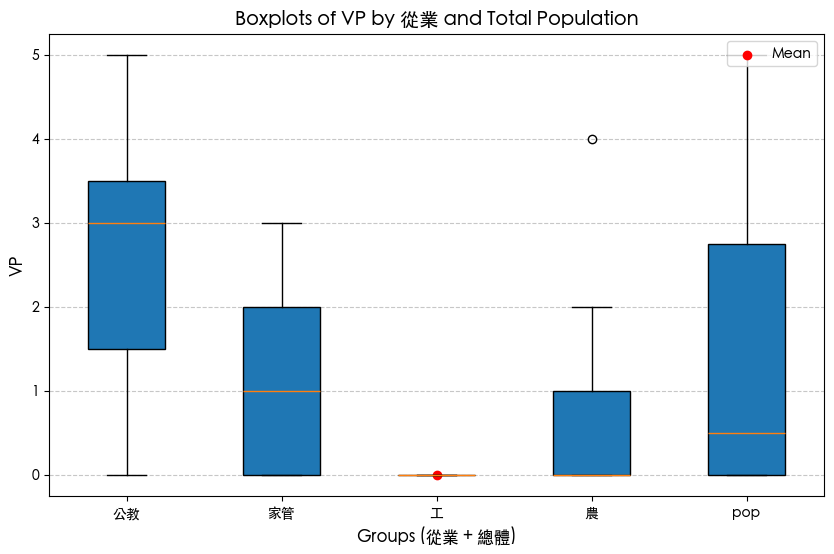

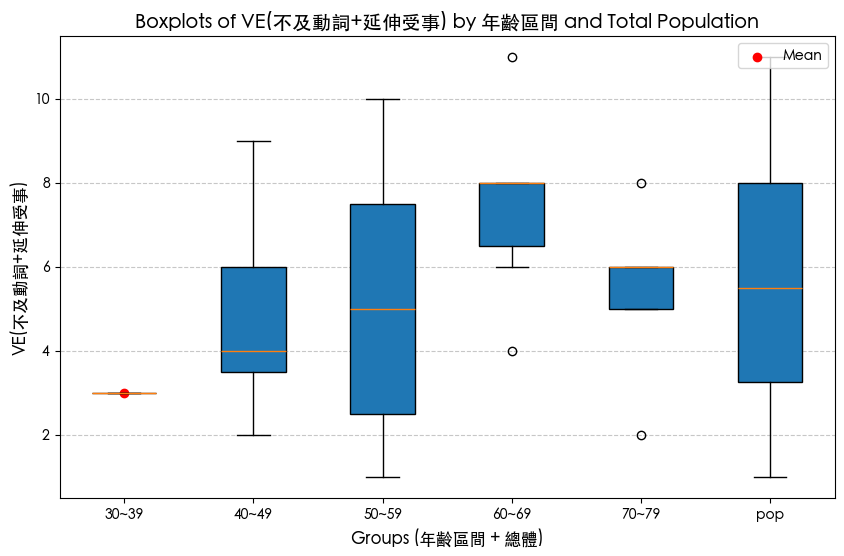

In [588]:

# from mean_test.csv
boxplot_(df, "從業", "VP")
boxplot_(df, "年齡區間", "VE(不及動詞+延伸受事)")

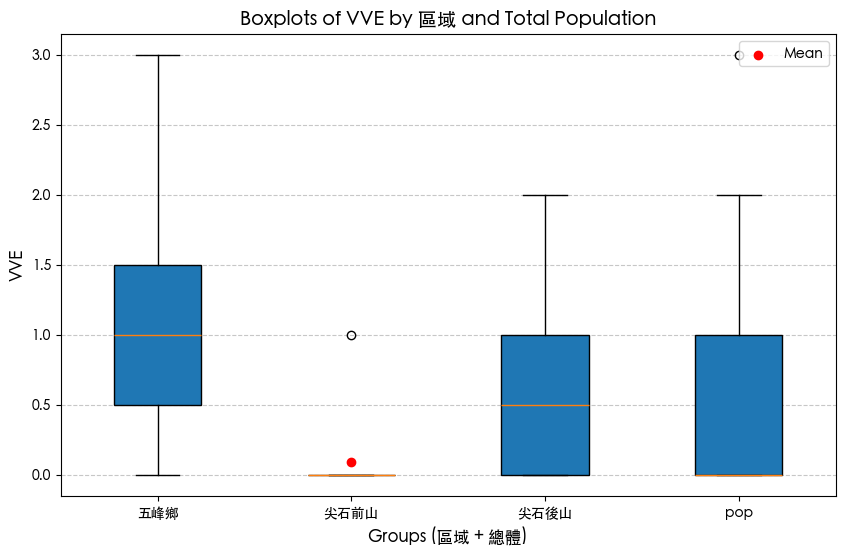

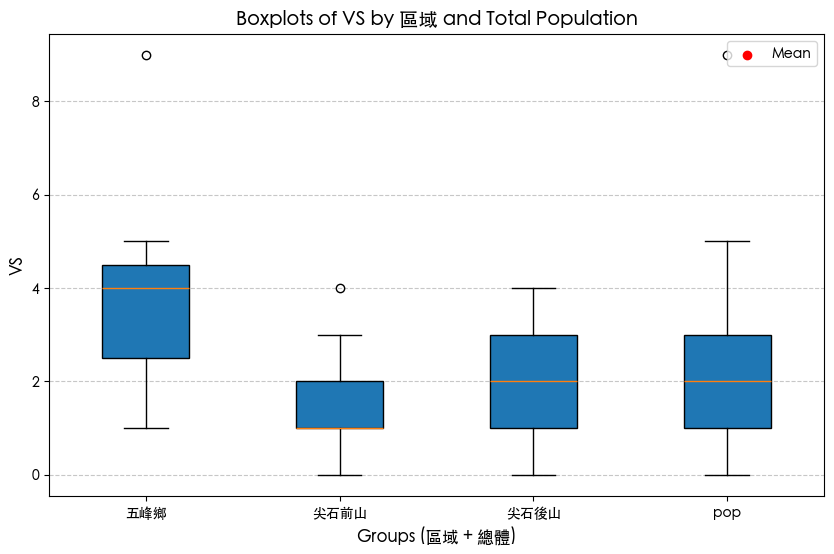

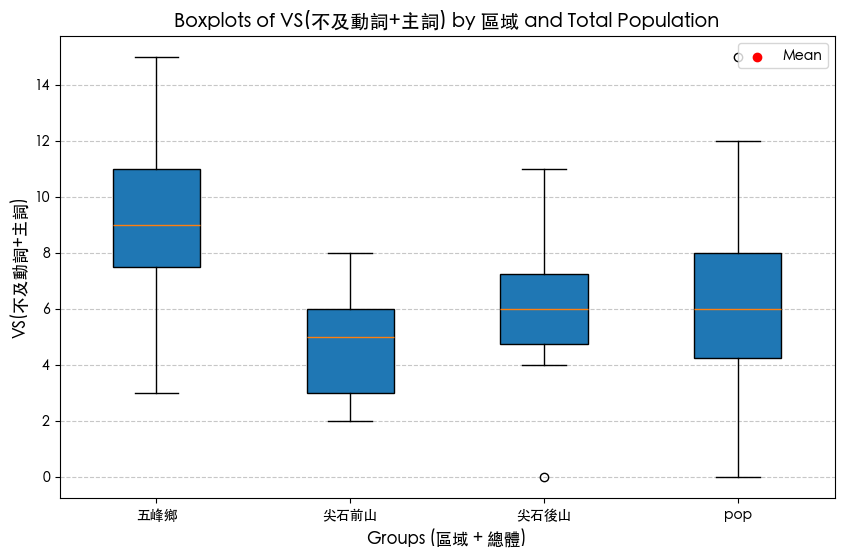

In [589]:
# box plot from grp_mean_test_.csv

boxplot_(df, "區域", "VVE")
boxplot_(df, "區域", "VS")
boxplot_(df, "區域", "VS(不及動詞+主詞)")



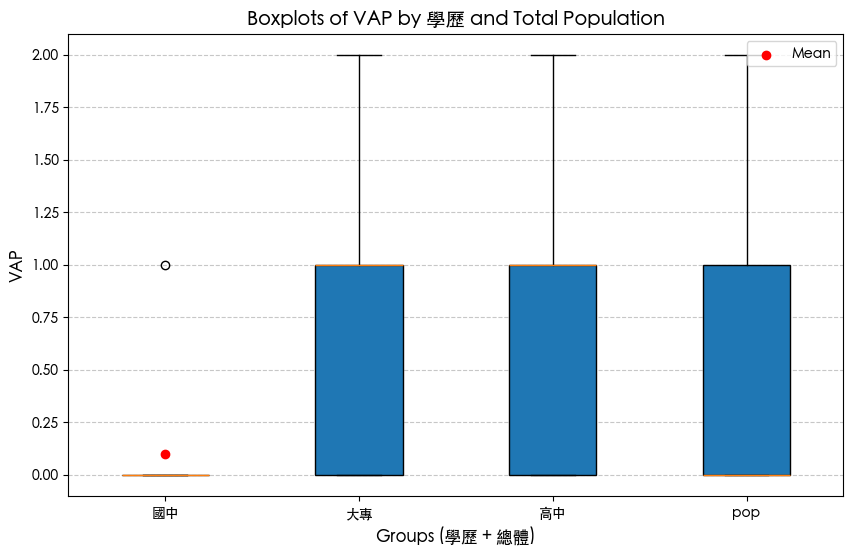

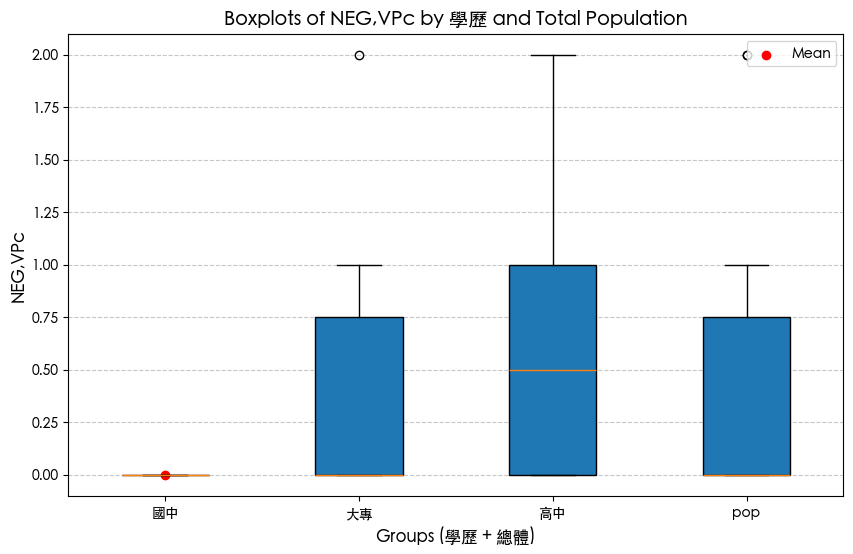

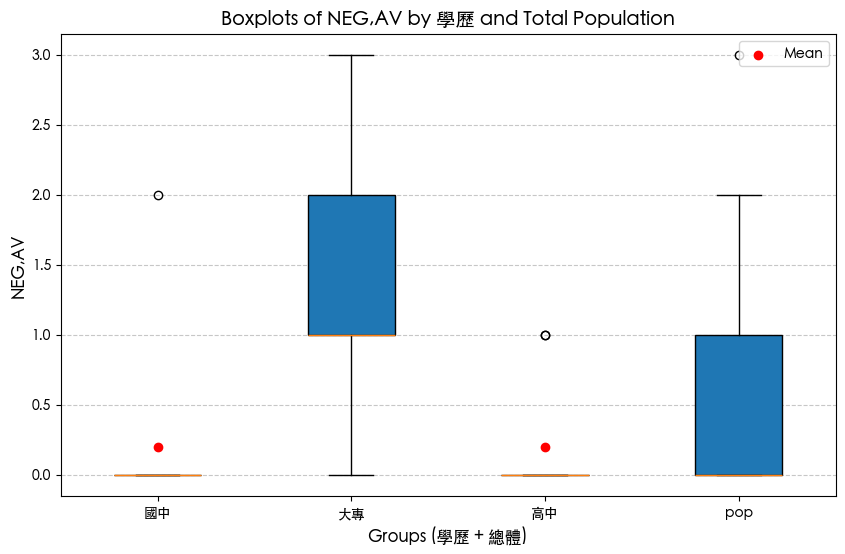

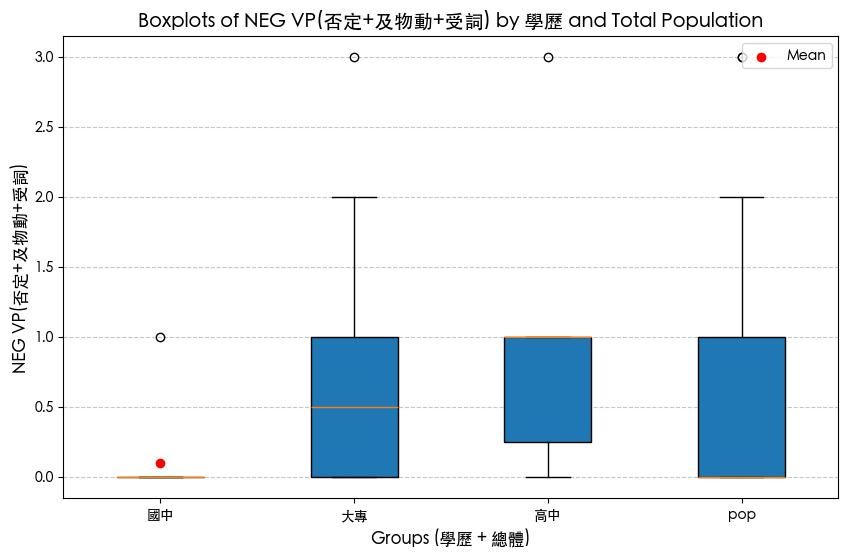

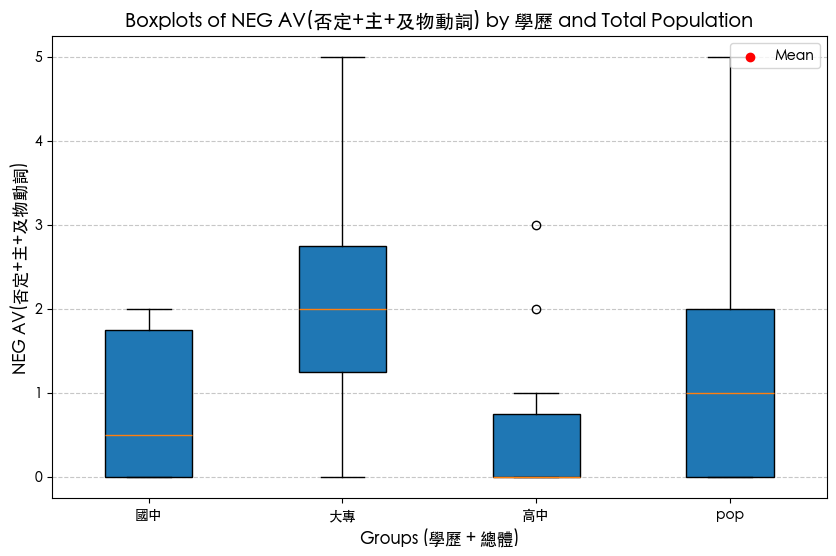

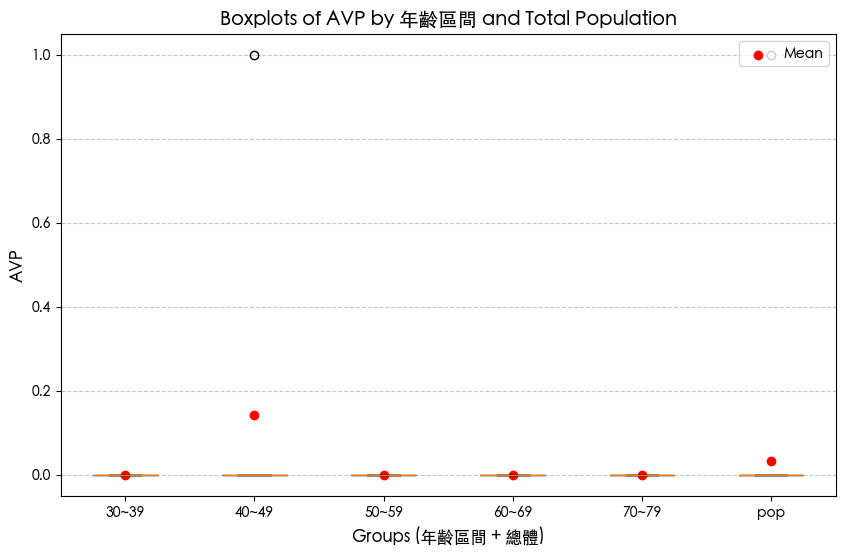

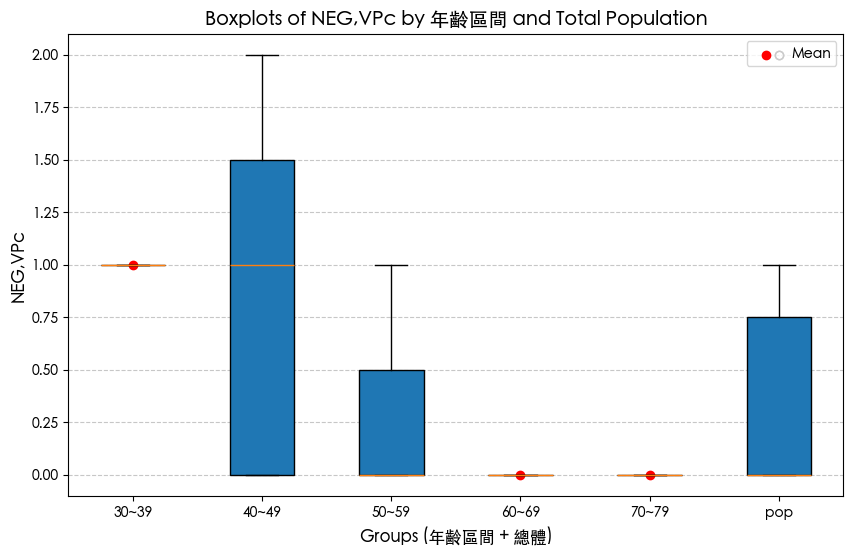

In [590]:
# box plot from grp_mean_test_.csv
boxplot_(df, "學歷", "VAP")
boxplot_(df, "學歷", "NEG,VPc")
boxplot_(df, "學歷", "NEG,AV")
boxplot_(df, "學歷", "NEG VP(否定+及物動+受詞)")
boxplot_(df, "學歷", "NEG AV(否定+主+及物動詞)")
boxplot_(df, "年齡區間", "AVP")
boxplot_(df, "年齡區間", "NEG,VPc")

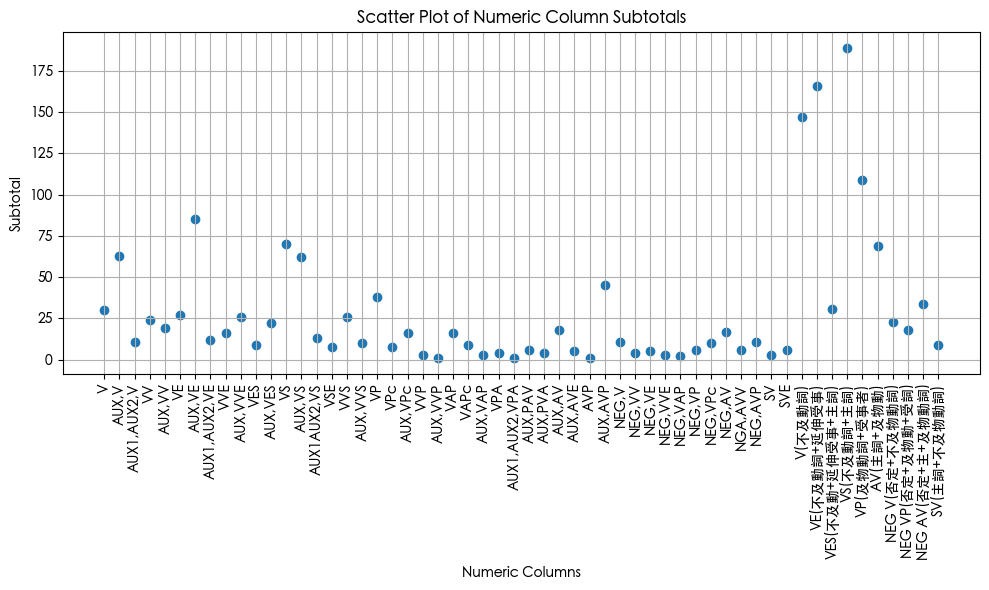

In [546]:
import matplotlib.pyplot as plt
import numpy as np

subtotals = df[numeric_columns].sum()

# Create a one-dimensional scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(subtotals.index, subtotals.values)
plt.xticks(rotation=90)
plt.title("Scatter Plot of Numeric Column Subtotals")
plt.xlabel("Numeric Columns")
plt.ylabel("Subtotal")
plt.grid(True)
plt.tight_layout()
plt.show()

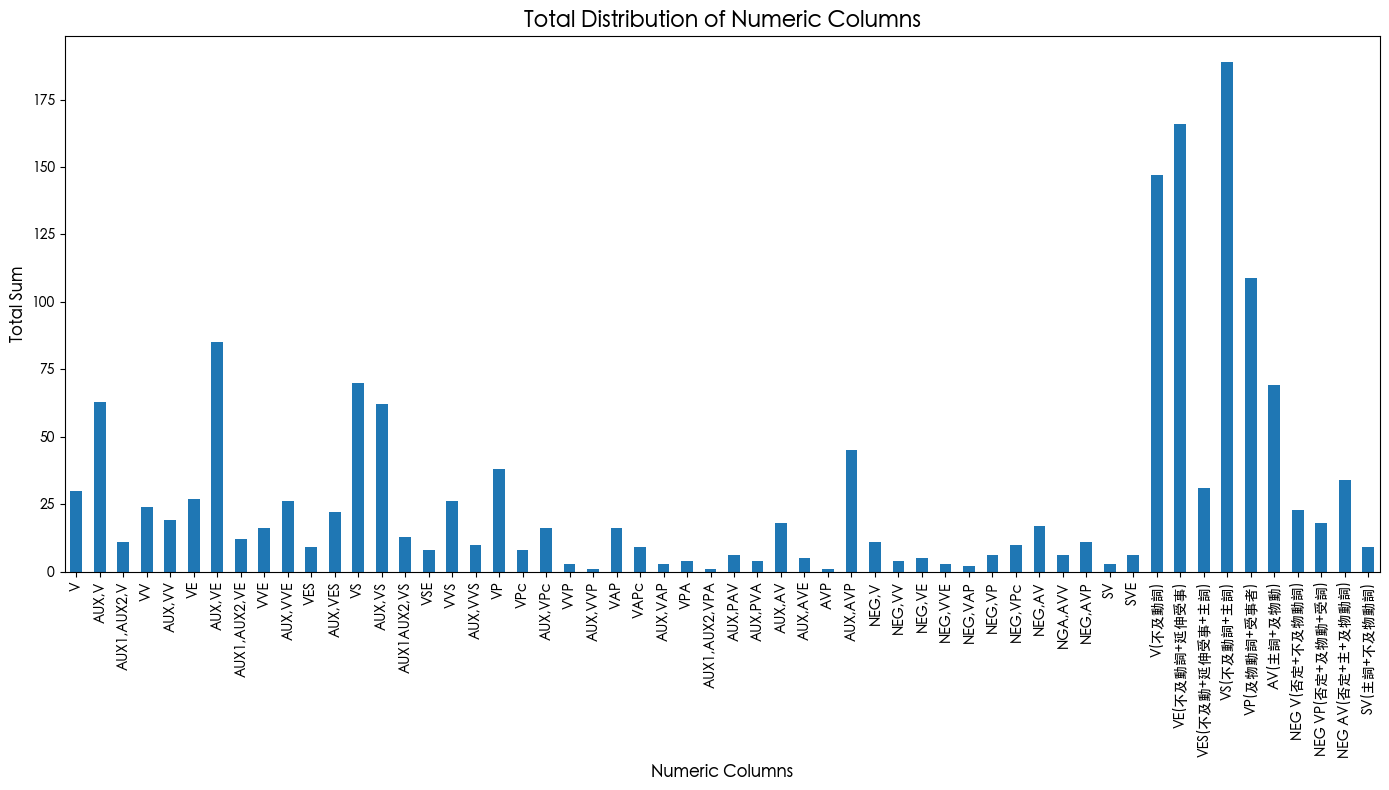

In [592]:

# Calculate subtotal for numeric columns grouped by '區域'


numeric_columns = df.select_dtypes(include=[np.number])

# Calculate the total sum for each numeric column
totals = numeric_columns.sum()

# Plot the distribution
plt.figure(figsize=(14, 8))
totals.plot(kind='bar')

# Add labels and title
plt.title("Total Distribution of Numeric Columns", fontsize=16)
plt.xlabel("Numeric Columns", fontsize=12)
plt.ylabel("Total Sum", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Mean: 28.392857142857142


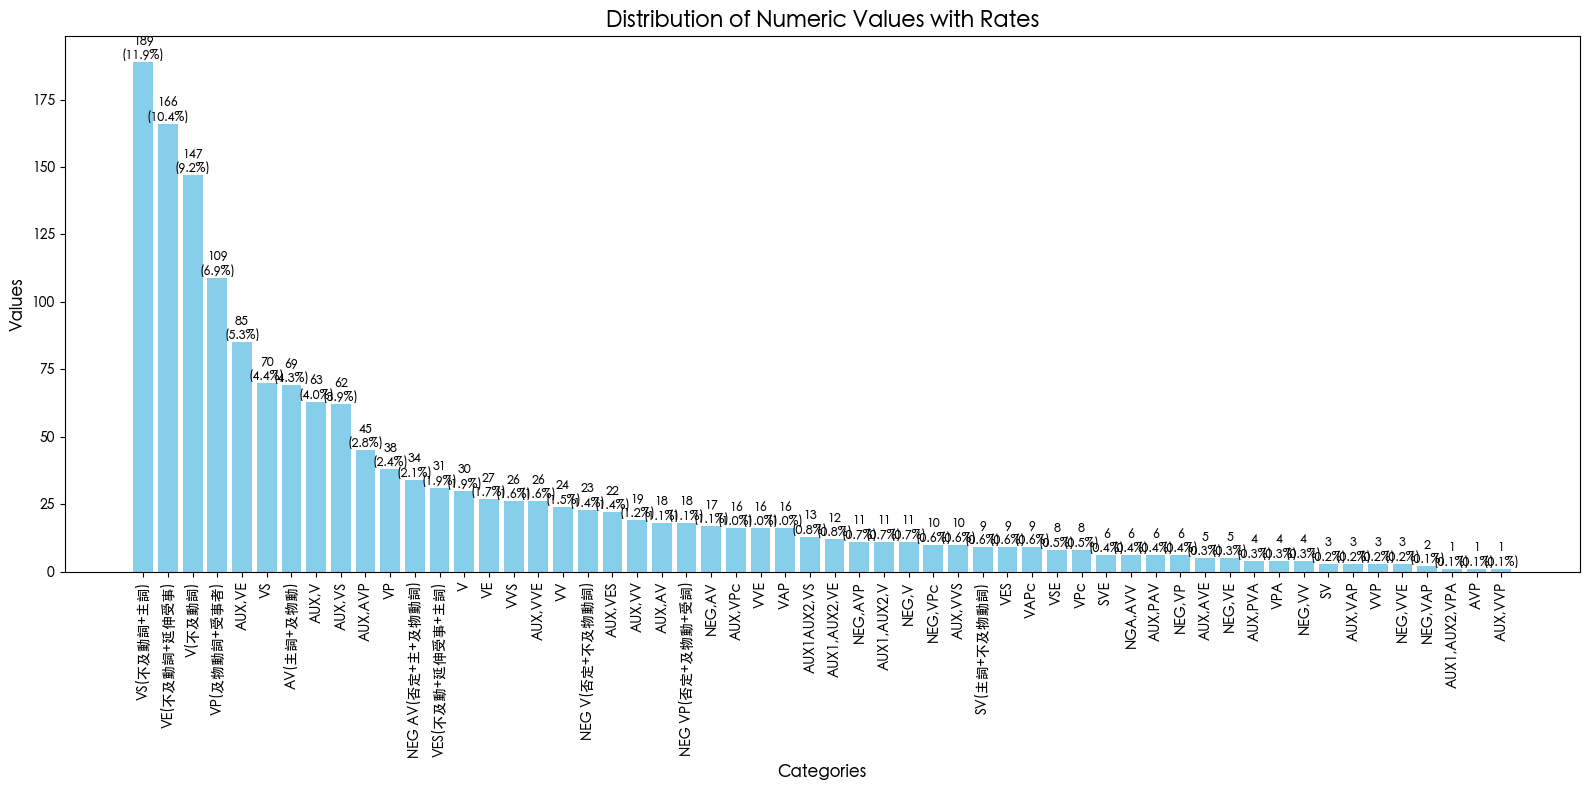

In [593]:
numeric_columns_by_dic = numeric_columns.to_dict()
numeric_columns_sum = numeric_columns.sum()
#numeric_columns_by_dic

numeric_columns_sum_by_dc = numeric_columns_sum.to_dict()
# numeric_columns_sum_by_dc

series = numeric_columns.sum()
mean_value = series.mean()
print(f"Mean: {mean_value}")

# Sort series in descending order
sorted_series = series.sort_values(ascending=False)

# Calculate the total sum
total = series.sum()

# Plot the series
plt.figure(figsize=(16, 8))
bars = plt.bar(sorted_series.index, sorted_series, color='skyblue')

# Annotate bars with numbers and percentages
for bar, value in zip(bars, sorted_series):
    percentage = (value / total) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{int(value)}\n({percentage:.1f}%)',
        ha='center', va='bottom', fontsize=9
    )

# Add title and labels
plt.title("Distribution of Numeric Values with Rates", fontsize=16)
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# Show plot
plt.show()

Mean: 28.392857142857142
Deviations:
V                      1.607143
AUX,V                 34.607143
AUX1,AUX2,V          -17.392857
VV                    -4.392857
AUX,VV                -9.392857
VE                    -1.392857
AUX,VE                56.607143
AUX1,AUX2,VE         -16.392857
VVE                  -12.392857
AUX,VVE               -2.392857
VES                  -19.392857
AUX,VES               -6.392857
VS                    41.607143
AUX,VS                33.607143
AUX1AUX2,VS          -15.392857
VSE                  -20.392857
VVS                   -2.392857
AUX,VVS              -18.392857
VP                     9.607143
VPc                  -20.392857
AUX,VPc              -12.392857
VVP                  -25.392857
AUX,VVP              -27.392857
VAP                  -12.392857
VAPc                 -19.392857
AUX,VAP              -25.392857
VPA                  -24.392857
AUX1,AUX2,VPA        -27.392857
AUX,PAV              -22.392857
AUX,PVA              -24.392857
AUX

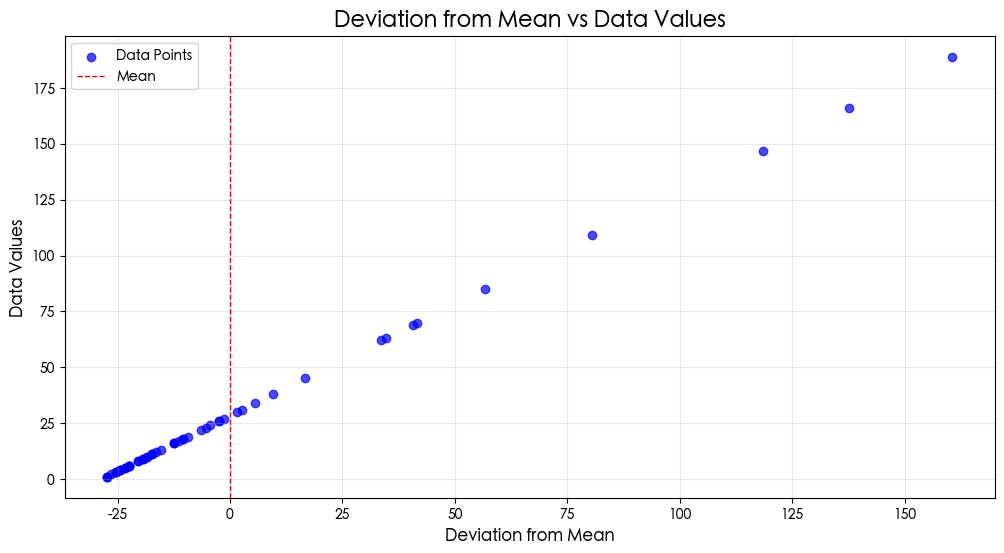

In [549]:
# Calculate the mean
mean = series.mean()

# Calculate the deviation (distance from the mean)
deviation = series - mean

# Print calculated values
print(f"Mean: {mean}")
print(f"Deviations:\n{deviation}")

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(deviation, series, color='blue', alpha=0.7, label="Data Points")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1, label="Mean")

# Add labels and title
plt.title("Deviation from Mean vs Data Values", fontsize=16)
plt.xlabel("Deviation from Mean", fontsize=12)
plt.ylabel("Data Values", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

# Show plot
plt.show()

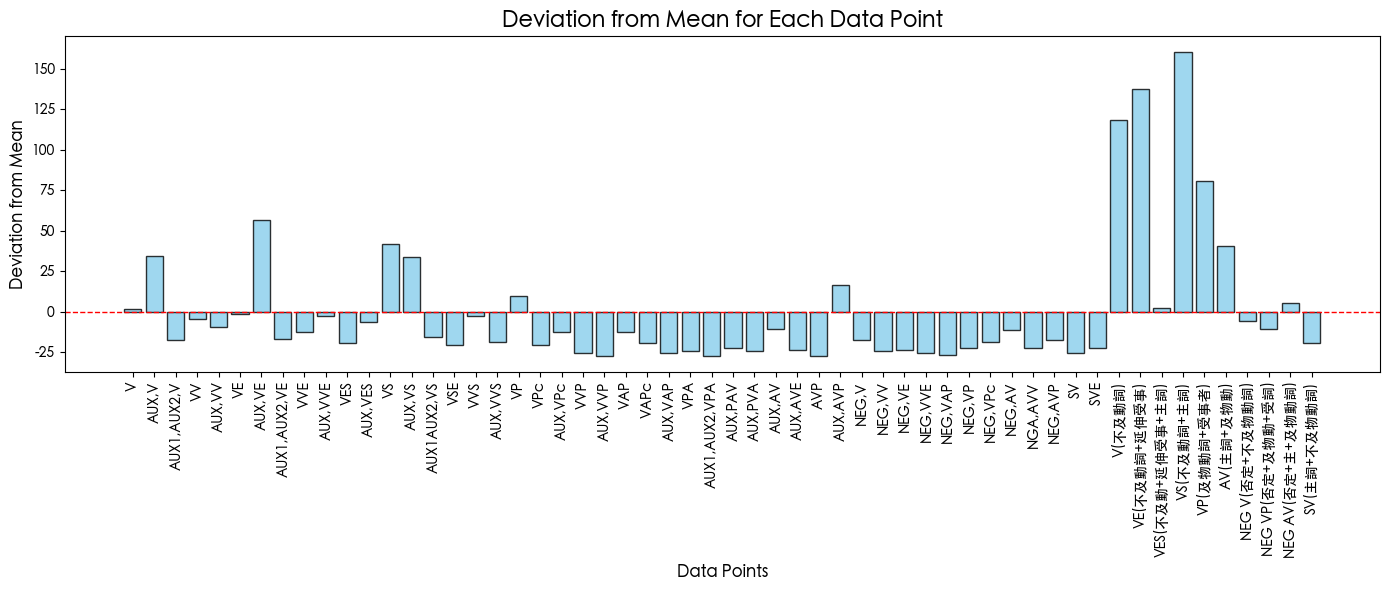

In [550]:
# Create bins (10 equal intervals)
bins = 10
bin_edges = pd.cut(deviation, bins=bins, retbins=True, labels=False)[1]  # Get bin edges
bin_labels = [f"{bin_edges[i]:.2f} to {bin_edges[i+1]:.2f}" for i in range(len(bin_edges) - 1)]

# Count how many points fall into each bin
bin_counts = pd.cut(deviation, bins=bins).value_counts(sort=False)


# Plot the data
plt.figure(figsize=(14, 6))
plt.bar(deviation.index, deviation.values, color='skyblue', edgecolor='black', alpha=0.8)

# Add labels and title
plt.title("Deviation from Mean for Each Data Point", fontsize=16)
plt.xlabel("Data Points", fontsize=12)
plt.ylabel("Deviation from Mean", fontsize=12)
plt.xticks(rotation=90)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a horizontal line at 0 for reference

# Show plot
plt.tight_layout()
plt.show()

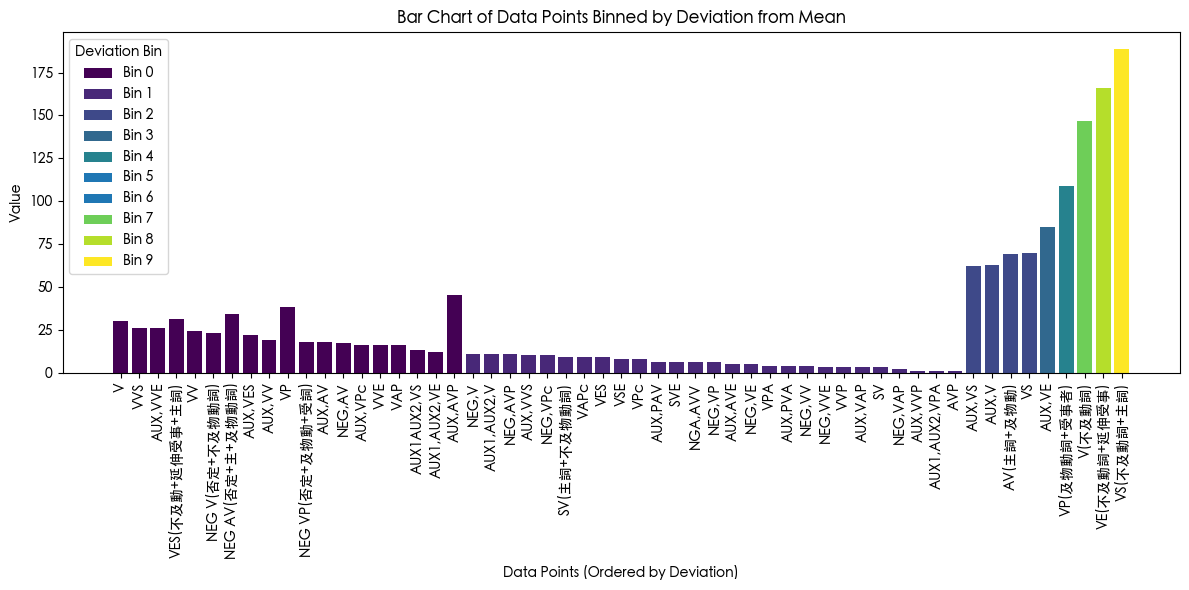

In [551]:
import numpy as np
# 計算平均值和偏差
mean_value = series.mean()
deviations = np.abs(series - mean_value)

# 建立偏差的分箱
bins = np.linspace(deviations.min(), deviations.max(), 11)
bin_labels = pd.cut(deviations, bins, labels=False)

# 建立用於排序和繪圖的 DataFrame
df = pd.DataFrame({
    'Value': series,
    'Deviation': deviations,
    'Bin': bin_labels
}).sort_values(by='Deviation')

# 繪製條形圖
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 生成分箱的顏色
for bin_idx in range(10):
    bin_data = df[df['Bin'] == bin_idx]
    plt.bar(bin_data.index, bin_data['Value'], color=colors[bin_idx], label=f'Bin {bin_idx}')

# 自訂圖表
plt.xticks(rotation=90)
plt.xlabel("Data Points (Ordered by Deviation)")
plt.ylabel("Value")
plt.title("Bar Chart of Data Points Binned by Deviation from Mean")
plt.legend(title="Deviation Bin")
plt.tight_layout()
plt.show()

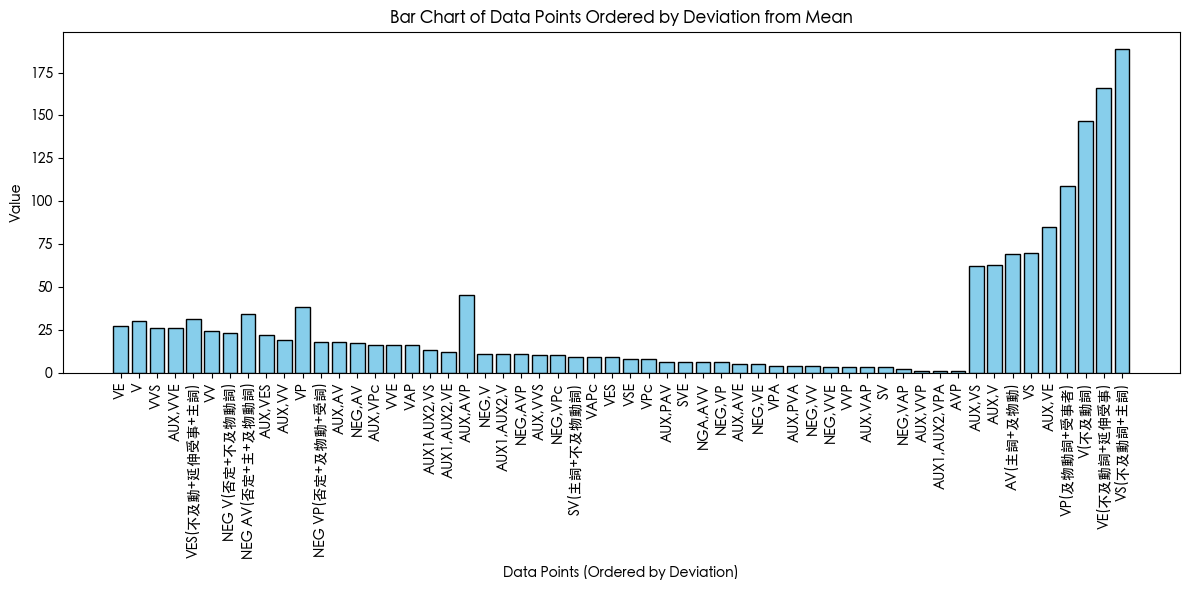

In [552]:
# Create a DataFrame for sorting and plotting
df = pd.DataFrame({
    'Value': series,
    'Deviation': deviations
}).sort_values(by='Deviation')

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['Value'], color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel("Data Points (Ordered by Deviation)")
plt.ylabel("Value")
plt.title("Bar Chart of Data Points Ordered by Deviation from Mean")
plt.tight_layout()
plt.show()


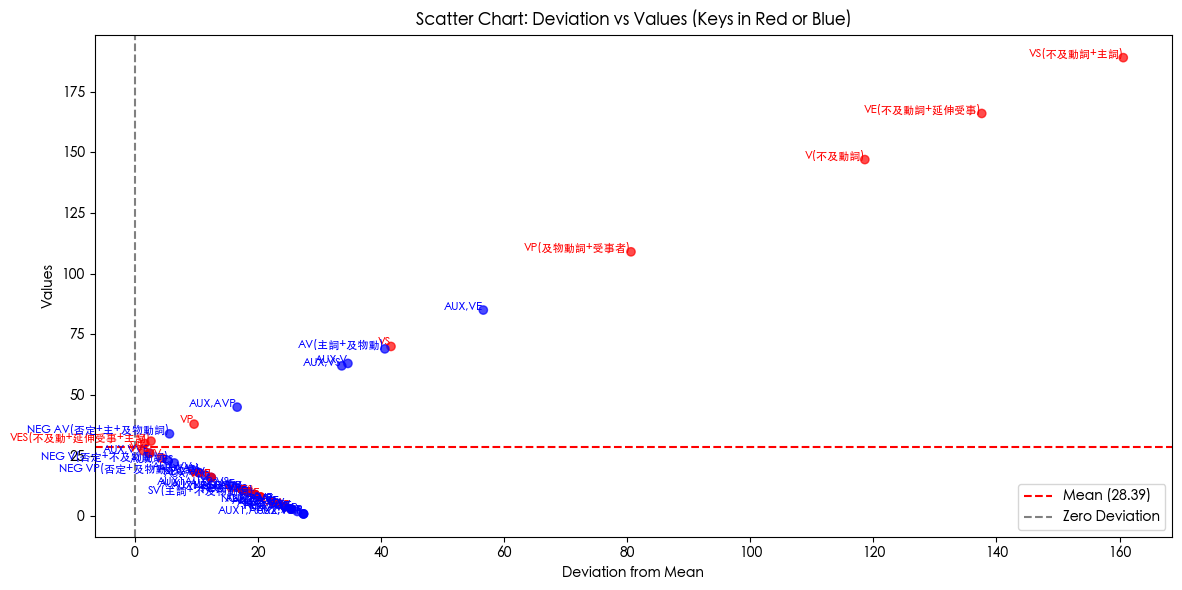

In [553]:
# Determine colors based on key
colors = ['red' if key.startswith('V') else 'blue' for key in series.index]

# Plot the scatter chart
plt.figure(figsize=(12, 6))
plt.scatter(deviations, series, c=colors, alpha=0.7)
for key, x, y, color in zip(series.index, deviations, series, colors):
    plt.text(x, y, key, fontsize=8, ha='right', color=color)

plt.axhline(mean_value, color='red', linestyle='--', label=f"Mean ({mean_value:.2f})")
plt.axvline(0, color='gray', linestyle='--', label="Zero Deviation")
plt.xlabel("Deviation from Mean")
plt.ylabel("Values")
plt.title("Scatter Chart: Deviation vs Values (Keys in Red or Blue)")
plt.legend()
plt.tight_layout()
plt.show()


In [609]:

df = pd.read_csv("iu_ataya_hsinchu_de01.csv")
df = df.loc[:, ~(df.columns.str.contains('^Unnamed') | (df.columns == ""))]
df

,姓名,區域,年齡區間,學歷,從業,V,"AUX,V","AUX1,AUX2,V",VV,"AUX,VV",...,"NEG,VE","NEG,VVE","NEG,VAP","NEG,VP","NEG,VPc","NEG,AV","NGA,AVV","NEG,AVP",SV,SVE
0,朱月珍,尖石前山,60~69,國中,家管,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,張貞英,尖石前山,50~59,大專,公教,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,張世傑,尖石前山,40~49,大專,公教,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,田美齡,尖石前山,70~79,國中,家管,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,陳英妹,尖石前山,70~79,國中,家管,0.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,楊小萍,尖石前山,50~59,高中,家管,1.0,3.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Apang,尖石前山,50~59,大專,公教,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
7,鄭Sayun,尖石前山,40~49,高中,家管,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
8,Reci,尖石前山,70~79,國中,家管,2.0,3.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
9,Syawling,尖石前山,70~79,國中,家管,0.0,5.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [611]:


# Step 1: Calculate the overall rate for each numeric column
numeric_cols = [col for col in df.columns if col not in ['姓名', '區域', '年齡區間', '學歷', '從業']]

# Total sum of all numeric columns
total_numeric_sum = df[numeric_cols].sum().sum()

# Calculate the overall rates (sum of column / total sum of all columns)
overall_rates = df[numeric_cols].sum() / total_numeric_sum

# Step 2: Calculate the rate for each '姓名'
df['Total'] = df[numeric_cols].sum(axis=1)  # Sum of all numeric columns for each individual
df_rates = df[numeric_cols].div(df['Total'], axis=0)  # Divide each numeric column by the individual's total

# Merge the calculated rates back into the DataFrame
df[numeric_cols] = df_rates

# Display results
print("Overall Rates for each column:")
print(overall_rates)
print("\nIndividual Rates for each '姓名':")
print(df[numeric_cols])

Overall Rates for each column:
V                0.001118
AUX,V            0.002720
AUX1,AUX2,V      0.000520
VV               0.001174
AUX,VV           0.000874
VE               0.001181
AUX,VE           0.004300
AUX1,AUX2,VE     0.000523
VVE              0.000626
AUX,VVE          0.001470
VES              0.000408
AUX,VES          0.001062
VS               0.003244
AUX,VS           0.002924
AUX1AUX2,VS      0.000655
VSE              0.000394
VVS              0.001057
AUX,VVS          0.000441
VP               0.001865
VPc              0.000339
AUX,VPc          0.000580
VVP              0.000086
AUX,VVP          0.000055
VAP              0.000838
VAPc             0.000363
AUX,VAP          0.000144
VPA              0.000160
AUX1,AUX2,VPA    0.000053
AUX,PAV          0.000234
AUX,PVA          0.000165
AUX,AV           0.000641
AUX,AVE          0.000252
AVP              0.000034
AUX,AVP          0.002117
NEG,V            0.000452
NEG,VV           0.000169
NEG,VE           0.000209
NEG,VVE

The Null Hypthesis is group mean for those 'ius' begin with 'V' is not greater than the avereage mean (polulaiton mean) 

- use one-sample ttest to test the null hypothesis is rejected, thus test to approve the group mean is greater than the population mean.
- 'V' 動詞在前的語句結構出現的頻率，一般來說會高於非動詞在前的語句結構。
- one sample T test 結果有顯著差異，也就是從統計數據支持以 'V' 開頭的語句結構，在該語境 (cookie-theft) 出現的頻率高於平均值。



In [596]:
# Step 1: Calculate the overall rate for each numeric column
numeric_cols = [col for col in df.columns if col not in ['姓名', '區域', '年齡區間', '學歷', '從業']]

# Total sum of all numeric columns
total_numeric_sum = df[numeric_cols].sum().sum()

# Calculate the overall rates (sum of column / total sum of all columns)
overall_rates = df[numeric_cols].sum() / total_numeric_sum

# Step 2: Calculate the rate for each '姓名'
df['Total'] = df[numeric_cols].sum(axis=1)  # Sum of all numeric columns for each individual
df_rates = df[numeric_cols].div(df['Total'], axis=0)  # Divide each numeric column by the individual's total
df_rates

,Unnamed: 0,V,"AUX,V","AUX1,AUX2,V",VV,"AUX,VV",VE,"AUX,VE","AUX1,AUX2,VE",VVE,...,"NEG,VVE","NEG,VAP","NEG,VP","NEG,VPc","NEG,AV","NGA,AVV","NEG,AVP",SV,SVE,Total
0,0.000000,0.000000,0.003096,0.000000,0.000000,0.003096,0.006192,0.009288,0.000000,0.000000,...,0.003096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,0.002506,0.000000,0.000000,0.000000,0.002506,0.000000,0.000000,0.005013,0.000000,0.000000,...,0.000000,0.002506,0.000000,0.000000,0.002506,0.000000,0.002506,0.000000,0.002506,1.0
2,0.003478,0.000000,0.000000,0.000000,0.000000,0.000000,0.001739,0.003478,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.001739,0.001739,0.001739,0.000000,0.000000,0.001739,1.0
3,0.006211,0.000000,0.000000,0.000000,0.000000,0.000000,0.004141,0.012422,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,0.005495,0.000000,0.002747,0.001374,0.001374,0.000000,0.000000,0.005495,0.000000,0.001374,...,0.000000,0.000000,0.001374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
5,0.005952,0.001190,0.003571,0.001190,0.000000,0.001190,0.000000,0.003571,0.002381,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001190,0.000000,1.0
6,0.007143,0.001190,0.002381,0.000000,0.000000,0.000000,0.000000,0.001190,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002381,0.000000,0.000000,0.000000,0.000000,1.0
7,0.008333,0.000000,0.002381,0.000000,0.000000,0.000000,0.000000,0.002381,0.000000,0.000000,...,0.000000,0.000000,0.001190,0.002381,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
8,0.003953,0.000988,0.001482,0.000988,0.000000,0.000494,0.000494,0.001976,0.000494,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000988,0.000000,0.000000,0.000000,0.000000,1.0
9,0.008272,0.000000,0.004596,0.000000,0.001838,0.000919,0.000000,0.003676,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000919,0.000919,0.000000,0.000000,1.0


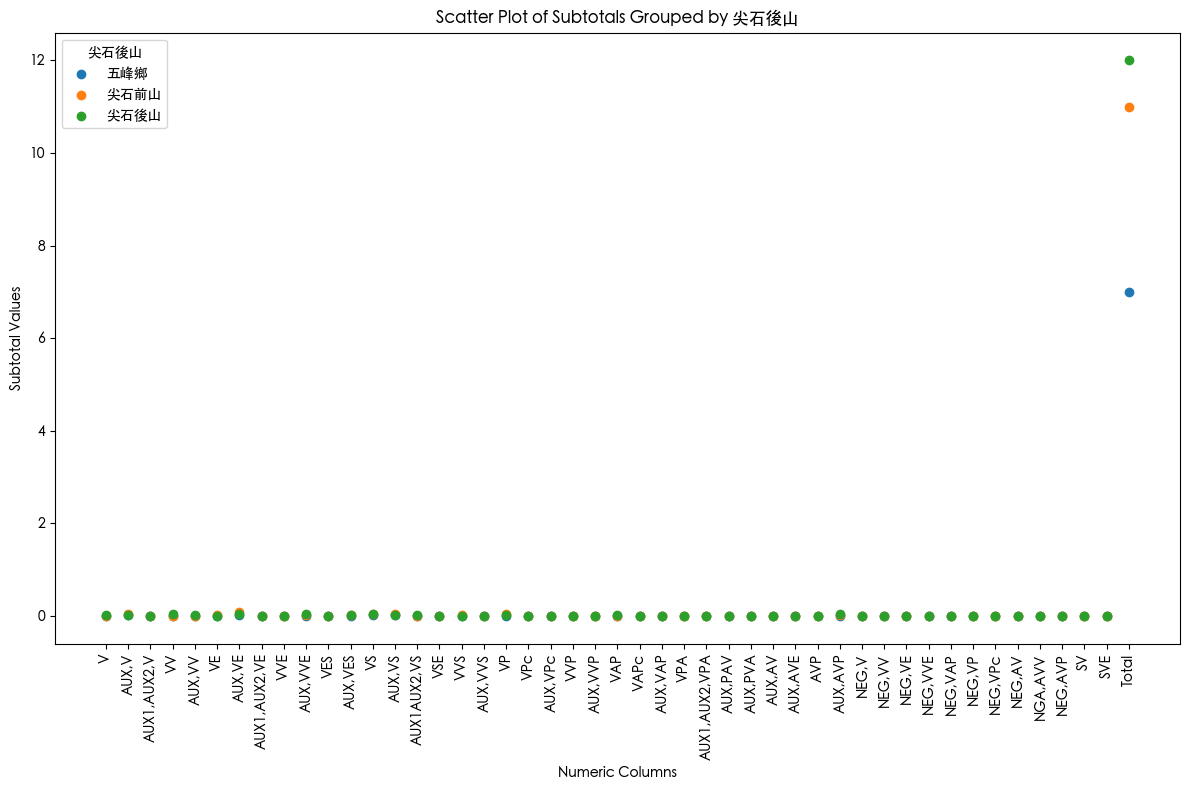

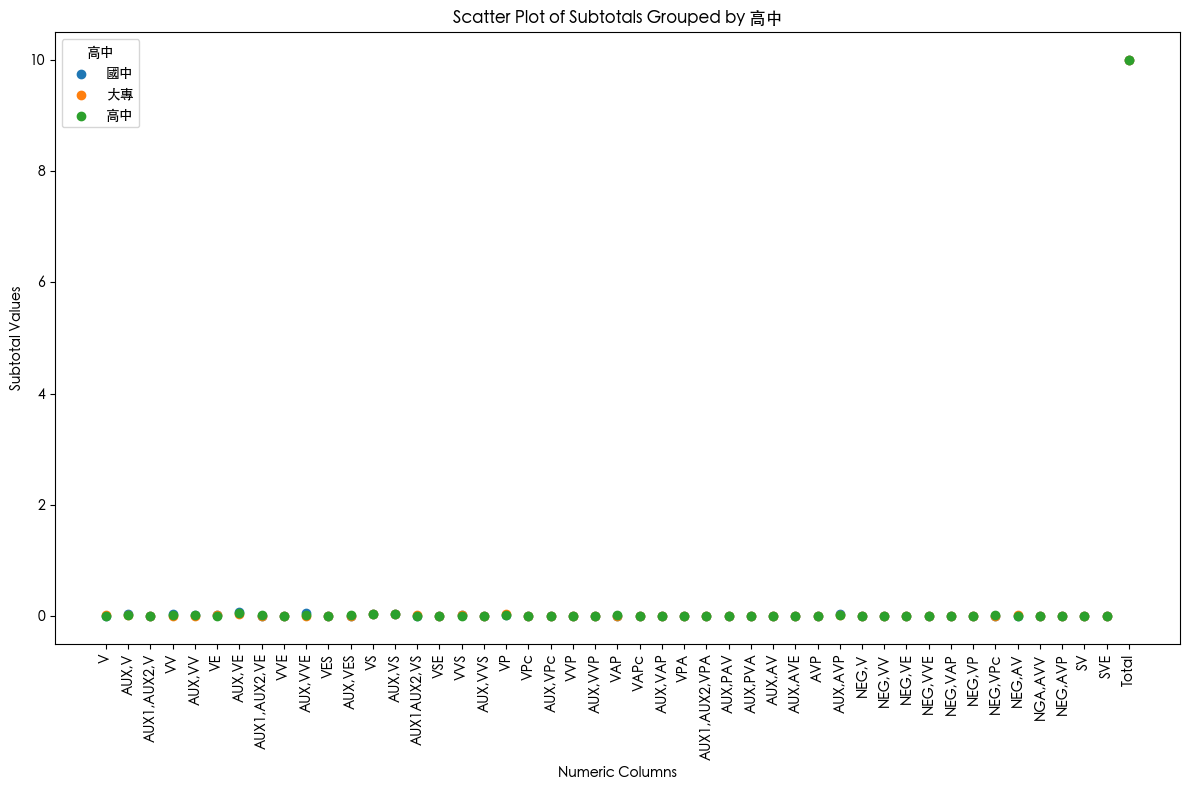

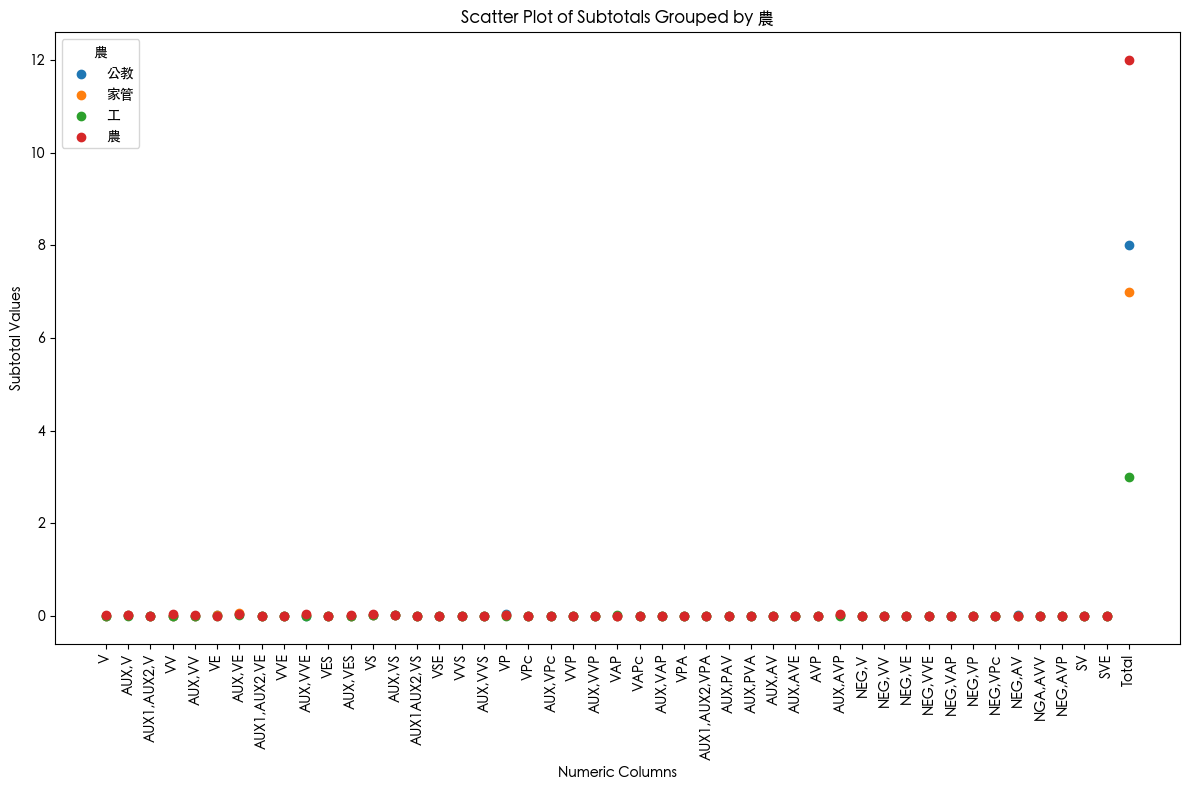

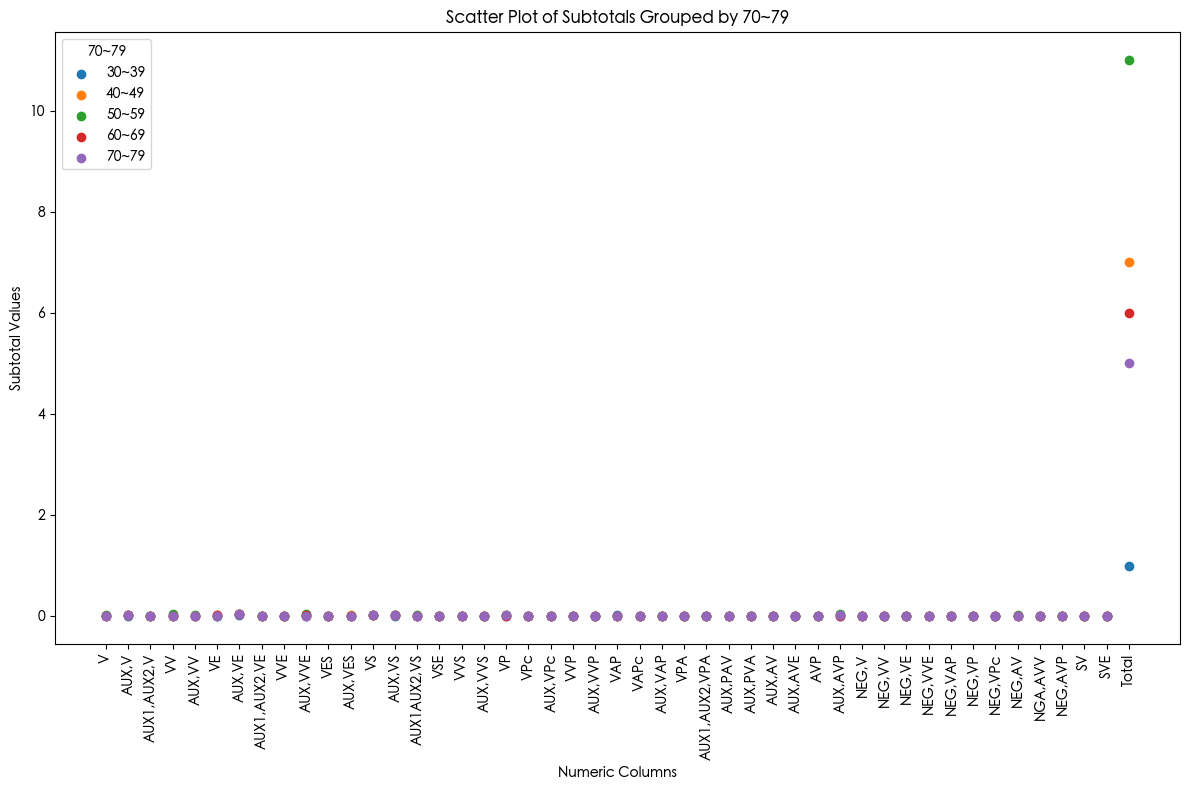

In [612]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
names = df["姓名"]
area = df["區域"]
edu = df["學歷"]
job = df["從業"]
age = df["年齡區間"]

# Configure font for Traditional Chinese
#rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # Replace with the name of your installed font
# Configure font for Traditional Chinese on macOS
# rcParams['font.sans-serif'] = ['PingFang TC']  # Use a macOS font that supports Traditional Chinese
rcParams['font.sans-serif'] = ['Heiti TC' ] 
rcParams['axes.unicode_minus'] = False  # Ensure minus signs display correctly


def plot_by_dim(dim):
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    # Calculate subtotal for numeric columns grouped by '區域'
    subtotals = df.groupby(dim)[numeric_columns].sum()

    # Plot the scatter plot
    plt.figure(figsize=(12, 8))
    for i, (dim, row) in enumerate(subtotals.iterrows()):
        x = range(len(numeric_columns))  # Numeric columns as the x-axis
        y = row.values  # Subtotal values for each numeric column
        plt.scatter(x, y, label=dim)

    # Add labels and format
    plt.xticks(range(len(numeric_columns)), numeric_columns, rotation=90)
    plt.xlabel("Numeric Columns")
    plt.ylabel("Subtotal Values")
    plt.title(f"Scatter Plot of Subtotals Grouped by {dim}")
    plt.legend(title=dim)
    plt.tight_layout()
    plt.show()

plot_by_dim(area)

plot_by_dim(edu)

plot_by_dim(job)

plot_by_dim(age)


在散佈圖上，每一個 ius 為一個點，如果是全部，也就是在所有的測試樣本中，個別 ius 出現的總數，會在一唯

分析步驟
1. 30 位受測者，共說了幾個句子 total_sum_ius
2. 每一種 ius ，在此份測試資料集所出現的次數 {"V":n1, "VA":n2, "VAP":n3 ..}
3. 每一種 ius ，在此份測試資料集所出現的頻率 {"V":r1, "VA":r2, "VAP":r3 ..} = {"V":n1/total_sum_ius, "VA":n2total_sum_ius, "VAP":n3/total_sum_ius ..}
4. 每一位受測者，subtotal_sum_ius_by_id ->  算出每一個 ius 出現的頻率


# 建議進一步分析方向
Cokiecept 為一固定場景，有不同主體，如 媽媽、男孩、女孩等。

In [533]:

subgroups.values

array([list([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]),
       list([0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0]),
       list([1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0]),
       list([0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0])],
      dtype=object)

In [558]:
df.columns

Index(['Value', 'Deviation', 'Total'], dtype='object')

In [284]:
from tabulate import tabulate
import numpy as np


# Extract columns starting with "V"
v_columns = [col for col in df.columns if col.startswith("V")]
v_data = df[v_columns]
v_data

# Extract columns starting with "V"
_neg_v_columns = [col for col in df.columns if not col.startswith("V") and col not in ['姓名', '區域', '年齡區間', '學歷', '從業']]
_neg_v_data = df[_neg_v_columns]
_neg_v_columns
#_neg_v_data.sum()

['APVA',
 'AV',
 'AVE',
 'AVP',
 'AVPV',
 'AVV',
 'AVVE',
 'AVVP',
 'EVS',
 'EVSV',
 'EVV',
 'ES',
 'ESV',
 'PAV',
 'PAVV',
 'PVA',
 'S',
 'SE',
 'SEV',
 'SV',
 'SVE',
 'SVV',
 'SVVE',
 'SVVS',
 'SVVV',
 'Total',
 'Sum_of_Means',
 'Sum_of_Variances']

In [662]:

percetage_by_grantotal = True
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns

# Group sum
grouped = df.groupby(categorical_columns)[numeric_columns].sum()

grant_total = grouped.sum(axis=0).values.sum()
if percetage_by_grantotal:
    grant_total_percentage = grouped.div(grant_total, axis=0) * 100
# Calculate percentage within each group
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Filter out rows where all numeric columns are NaN
grouped = grouped.dropna(how='all')
grouped_percentage = grouped_percentage.dropna(how='all')
if percetage_by_grantotal: grant_total_percentage = grant_total_percentage.dropna(how='all')


# Filter out rows where all numeric columns are zero
grouped = grouped[(grouped != 0).any(axis=1)]
grouped_percentage = grouped_percentage[(grouped_percentage != 0).any(axis=1)]
if percetage_by_grantotal: grant_total_percentage = grant_total_percentage[(grant_total_percentage != 0).any(axis=1)]
# Format grouped values as integers
grouped = grouped.astype(int)

# Format grouped percentages to three decimal places (ceiling to 10^-3)
grouped_percentage = grouped_percentage.applymap(lambda x: np.ceil(x * 100) / 100)
if percetage_by_grantotal: grant_total_percentage = grant_total_percentage.applymap(lambda x: np.ceil(x * 100) / 100)

# Merge sums and percentages for each numeric column
merged_grouped = grouped.copy()
for col in grouped.columns:
    if percetage_by_grantotal:
        merged_grouped[col] = (
            grouped[col].astype(int).astype(str) + 
            " (" +
            grouped_percentage[col].round(3).astype(str) + 
            "%)" +
            " (" +
            grant_total_percentage[col].round(3).astype(str) + 
            "%)"
        )
    else:            
        merged_grouped[col] = (
            grouped[col].astype(int).astype(str) + 
            " (" +
            grouped_percentage[col].round(3).astype(str) + 
            "%)"
        )
transpose = True
# Convert to Markdown table
if transpose: merged_grouped_markdown = merged_grouped.T.reset_index().to_markdown(index=False, tablefmt="pipe")
else: merged_grouped_markdown = merged_grouped.reset_index().to_markdown(index=False, tablefmt="pipe")

In [629]:
percetage_by_grantotal = True
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns
df
# Group sum
grouped = df.groupby(categorical_columns)[numeric_columns].sum()

grouped

,V,"AUX,V","AUX1,AUX2,V",VV,"AUX,VV",VE,"AUX,VE","AUX1,AUX2,VE",VVE,"AUX,VVE",...,"NEG,VVE","NEG,VAP","NEG,VP","NEG,VPc","NEG,AV","NGA,AVV","NEG,AVP",SV,SVE,Total
年齡區間,,,,,,,,,,,,,,,,,,,,,
30~39,0.000000,0.005495,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,0.000000,0.005495,...,0.000000,0.000000,0.000000,0.005495,0.000000,0.000000,0.000000,0.000000,0.005495,1.0
40~49,0.003666,0.021069,0.006410,0.007569,0.006906,0.017742,0.048325,0.005080,0.002915,0.005839,...,0.001075,0.000000,0.003240,0.010809,0.006480,0.003240,0.005817,0.000000,0.002915,7.0
50~59,0.015138,0.019407,0.002778,0.031702,0.018155,0.002851,0.036134,0.005672,0.006691,0.043826,...,0.000947,0.003675,0.001566,0.002105,0.012841,0.000675,0.004757,0.001812,0.002924,11.0
60~69,0.009524,0.025440,0.004409,0.002801,0.005018,0.012842,0.033403,0.002742,0.004433,0.011242,...,0.003268,0.000000,0.000675,0.000000,0.001712,0.002632,0.000675,0.000726,0.002151,6.0
70~79,0.001502,0.015263,0.005016,0.007138,0.002562,0.006599,0.035698,0.002289,0.003515,0.003788,...,0.000000,0.000000,0.001976,0.000000,0.001502,0.003350,0.001812,0.000000,0.000000,5.0


In [613]:
import numpy as np
iudata = df
df = iudata.fillna(0)


def group_df_by_categ(df:pd.DataFrame, category:list, transpose=True, percetage_by_grantotal=True):
    numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns

    # Group sum
    grouped = df.groupby(categorical_columns)[numeric_columns].sum()

    grant_total = grouped.sum(axis=0).values.sum()
    if percetage_by_grantotal:
        grant_total_percentage = grouped.div(grant_total, axis=0) * 100
    # Calculate percentage within each group
    grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Filter out rows where all numeric columns are NaN
    grouped = grouped.dropna(how='all')
    grouped_percentage = grouped_percentage.dropna(how='all')
    if percetage_by_grantotal: grant_total_percentage = grant_total_percentage.dropna(how='all')


    # Filter out rows where all numeric columns are zero
    grouped = grouped[(grouped != 0).any(axis=1)]
    grouped_percentage = grouped_percentage[(grouped_percentage != 0).any(axis=1)]
    if percetage_by_grantotal: grant_total_percentage = grant_total_percentage[(grant_total_percentage != 0).any(axis=1)]
    # Format grouped values as integers
    grouped = grouped.astype(int)

    # Format grouped percentages to three decimal places (ceiling to 10^-3)
    grouped_percentage = grouped_percentage.applymap(lambda x: np.ceil(x * 100) / 100)
    if percetage_by_grantotal: grant_total_percentage = grant_total_percentage.applymap(lambda x: np.ceil(x * 100) / 100)

    # Merge sums and percentages for each numeric column
    merged_grouped = grouped.copy()
    for col in grouped.columns:
        if percetage_by_grantotal:
            merged_grouped[col] = (
                grouped[col].astype(int).astype(str) + 
                " (" +
                grouped_percentage[col].round(3).astype(str) + 
                "%)" +
                " (" +
                grant_total_percentage[col].round(3).astype(str) + 
                "%)"
            )
        else:            
            merged_grouped[col] = (
                grouped[col].astype(int).astype(str) + 
                " (" +
                grouped_percentage[col].round(3).astype(str) + 
                "%)"
            )

    # Convert to Markdown table
    if transpose: merged_grouped_markdown = merged_grouped.T.reset_index().to_markdown(index=False, tablefmt="pipe")
    else: merged_grouped_markdown = merged_grouped.reset_index().to_markdown(index=False, tablefmt="pipe")

    return merged_grouped_markdown
#
# Group by categorical columns
categorical_columns = ["區域", "學歷", "從業", "年齡區間"]
merged_grouped_markdown = group_df_by_categ(df, categorical_columns, transpose=False)
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)
# Group by categorical columns
categorical_columns = ["區域", "學歷", "從業", "年齡區間"]
merged_grouped_markdown = group_df_by_categ(df, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)
# Group by categorical columns
categorical_columns = ["區域"]
merged_grouped_markdown = group_df_by_categ(df, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)

categorical_columns = ["學歷"]
merged_grouped_markdown = group_df_by_categ(df, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)

categorical_columns = ["從業"]
merged_grouped_markdown = group_df_by_categ(df, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)

categorical_columns = ["年齡區間"]
merged_grouped_markdown = group_df_by_categ(df, categorical_columns)
# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)


Merged Group Result (Sum and Percentage for Each Numeric Column):
| 區域     | 學歷   | 從業   | 年齡區間   | V                 | AUX,V             | AUX1,AUX2,V       | VV                | AUX,VV            | VE                | AUX,VE            | AUX1,AUX2,VE      | VVE               | AUX,VVE           | VES               | AUX,VES           | VS                | AUX,VS            | AUX1AUX2,VS       | VSE               | VVS               | AUX,VVS           | VP                | VPc               | AUX,VPc           | VVP               | AUX,VVP           | VAP               | VAPc              | AUX,VAP           | VPA               | AUX1,AUX2,VPA     | AUX,PAV           | AUX,PVA           | AUX,AV            | AUX,AVE           | AVP               | AUX,AVP           | NEG,V             | NEG,VV            | NEG,VE            | NEG,VVE           | NEG,VAP           | NEG,VP            | NEG,VPc           | NEG,AV            | NGA,AVV           | NEG,AVP           | SV                | 

In [ ]:
# Basic Statistic
# - Grant Total -
grant_total = grouped.sum(axis=0)
print(f"Goup Total:{grant_total}")
grant_total = grouped.sum(axis=0).values.sum()

print(f"Grant Total:{grant_total}")
# - Overal Percentage by iu -
print(f"Overall Percentage by iu:")
overall_rates = grouped.sum(axis=0)/grant_total*100
overall_rates
overall_rates.T.round(3).astype(str) + "%"
overall_rates['PAV'].round(3).astype(str) + "%"
pva_and_misc_variants = ["EVS","EVSV","EVV","ES", "ESV", "PAV", "PAVV", "PVA"]
overall_rates[pva_and_misc_variants].round(3).astype(str) + "%"
overall_rates[pva_and_misc_variants].sum().round(3).astype(str) + "%"

Goup Total:V       42
VA       8
VAP     22
VAV      3
VAVE     3
        ..
SVE     56
SVV     19
SVVE    29
SVVS     3
SVVV     3
Length: 62, dtype: int64
Grant Total:774
Overall Percentage by iu:


'3.101%'

In [ ]:
from tabulate import tabulate
import numpy as np

df = iudata.fillna(0)

df["年齡範圍"] = pd.cut(df["年齡"], bins=range(0, 101, 10), right=False, labels=[f"{i}~{i+9}" for i in range(0, 100, 10)])
# Drop the original 年齡 column since it's no longer needed
df = df.drop(columns=["年齡"])

numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns

# Group sum
grouped = df.groupby(categorical_columns)[numeric_columns].sum()

# Calculate percentage within each group
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Filter out rows where all numeric columns are NaN
grouped = grouped.dropna(how='all')
grouped_percentage = grouped_percentage.dropna(how='all')
grouped = grouped.dropna(how='all')
grouped_percentage = grouped_percentage.dropna(how='all')

# Filter out rows where all numeric columns are zero
grouped = grouped[(grouped != 0).any(axis=1)]
grouped_percentage = grouped_percentage[(grouped_percentage != 0).any(axis=1)]

# Format grouped values as integers
grouped = grouped.astype(int)

# Format grouped percentages to three decimal places (ceiling to 10^-3)
grouped_percentage = grouped_percentage.applymap(lambda x: np.ceil(x * 100) / 100)


In [220]:
# Convert grouped to Markdown format
grouped_markdown = grouped.reset_index().to_markdown(index=False, tablefmt="pipe")

# Convert grouped_percentage to Markdown format
grouped_percentage_markdown = grouped_percentage.reset_index().to_markdown(index=False, tablefmt="pipe")

# Display Markdown tables
print("Grouped Sum (Formatted as Integers):")
print(grouped_markdown)
print("\nGrouped Percentage (Formatted to 3 Decimal Places, Ceiling):")
print(grouped_percentage_markdown)

Grouped Sum (Formatted as Integers):
| 區域     | 學歷   | 從業   | 年齡區間   |   V |   VA |   VAP |   VAV |   VAVE |   VAVP |   VAVV |   VE |   VEAV |   VES |   VESV |   VEV |   VEVE |   VEVS |   VP |   VPA |   VPV |   VPVA |   VPVE |   VS |   VSE |   VSES |   VSV |   VSVE |   VV |   VVA |   VVAP |   VVE |   VVEA |   VVES |   VVP |   VVS |   VVSE |   VVSV |   VVV |   VVVE |   VVVS |   APVA |   AV |   AVE |   AVP |   AVPV |   AVV |   AVVE |   AVVP |   EVS |   EVSV |   EVV |   ES |   ESV |   PAV |   PAVV |   PVA |   S |   SE |   SEV |   SV |   SVE |   SVV |   SVVE |   SVVS |   SVVV |   Ius數量小計 |
|:---------|:-------|:-------|:-----------|----:|-----:|------:|------:|-------:|-------:|-------:|-----:|-------:|------:|-------:|------:|-------:|-------:|-----:|------:|------:|-------:|-------:|-----:|------:|-------:|------:|-------:|-----:|------:|-------:|------:|-------:|-------:|------:|------:|-------:|-------:|------:|-------:|-------:|-------:|-----:|------:|------:|-------:|------:|-------:

In [70]:
# Calculate column-wise sum
column_sums = grouped.sum(axis=0)

# Calculate column-wise percentages
column_percentages = (column_sums / column_sums.sum()) * 100

# Convert column-wise sums and percentages to Markdown tables
column_sums_markdown = column_sums.reset_index().rename(columns={0: "Sum"}).to_markdown(index=False, tablefmt="pipe")
column_percentages_markdown = column_percentages.reset_index().rename(columns={0: "Percentage"}).to_markdown(index=False, tablefmt="pipe")

# Display the results
print("Column-Wise Sum:")
print(column_sums_markdown)
print("\nColumn-Wise Percentage:")
print(column_percentages_markdown)

Column-Wise Sum:
| index       |   Sum |
|:------------|------:|
| V           |    42 |
| VA          |     8 |
| VAP         |    22 |
| VAV         |     3 |
| VAVE        |     3 |
| VAVP        |     1 |
| VAVV        |     1 |
| VE          |    71 |
| VEAV        |     1 |
| VES         |    30 |
| VESV        |     1 |
| VEV         |     2 |
| VEVE        |     2 |
| VEVS        |     3 |
| VP          |    35 |
| VPA         |     3 |
| VPV         |     2 |
| VPVA        |     1 |
| VPVE        |     1 |
| VS          |   105 |
| VSE         |    17 |
| VSES        |     1 |
| VSV         |     9 |
| VSVE        |     3 |
| VV          |    23 |
| VVA         |     1 |
| VVAP        |     1 |
| VVE         |    28 |
| VVEA        |     1 |
| VVES        |     5 |
| VVP         |     6 |
| VVS         |    40 |
| VVSE        |     1 |
| VVSV        |     2 |
| VVV         |    11 |
| VVVE        |     4 |
| VVVS        |     2 |
| APVA        |     1 |
| AV          |    13 |

In [ ]:


# Group by categorical columns
categorical_columns = ["區域", "學歷"]
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns

# Group sum
grouped = df.groupby(categorical_columns)[numeric_columns].sum()

# Calculate percentage within each group
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Filter out rows where all numeric columns are NaN
grouped = grouped.dropna(how='all')
grouped_percentage = grouped_percentage.dropna(how='all')
grouped = grouped.dropna(how='all')
grouped_percentage = grouped_percentage.dropna(how='all')

# Transpose the grouped DataFrame (swap rows and columns)
grouped_transposed = grouped.T

# Convert the transposed result into a Markdown table
grouped_transposed_markdown = grouped_transposed.to_markdown(tablefmt="pipe")

# Transpose the grouped_percentage DataFrame (swap rows and columns)
grouped_percentage_transposed = grouped_percentage.T

# Convert the transposed result into a Markdown table
grouped_percentage_transposed_markdown = grouped_percentage_transposed.to_markdown(tablefmt="pipe")

# Display the transposed table
print("Transposed Grouped Result:")
print(grouped_transposed_markdown)

print("Transposed Grouped Percentage Result:")
print(grouped_percentage_transposed_markdown)





Transposed Grouped Result:
|             |   ('五峰鄉', '國中') |   ('五峰鄉', '大專') |   ('尖石前山', '國中') |   ('尖石前山', '大專') |   ('尖石前山', '高中') |   ('尖石後山', '國中') |   ('尖石後山', '大專') |   ('尖石後山', '高中') |
|:------------|---------------------:|---------------------:|-----------------------:|-----------------------:|-----------------------:|-----------------------:|-----------------------:|-----------------------:|
| V           |                    3 |                    8 |                      6 |                      1 |                      1 |                      5 |                      6 |                     12 |
| VA          |                    0 |                    0 |                      1 |                      3 |                      0 |                      1 |                      2 |                      1 |
| VAP         |                    1 |                    1 |                      0 |                      3 |                      3 |                      0 |          

In [ ]:
# Calculate sums grouped by '區域' and '學歷'
column_sums_grouped = grouped.groupby(["區域", "學歷"]).sum(numeric_only=True)

# Calculate percentages for each column within each group
column_percentages_grouped = column_sums_grouped.div(column_sums_grouped.sum(axis=1), axis=0) * 100

# Merge sums and percentages for each numeric column
merged_grouped = column_sums_grouped.copy()
for col in column_sums_grouped.columns:
    merged_grouped[col] = (
        column_sums_grouped[col].astype(int).astype(str) + 
        " (" +
        column_percentages_grouped[col].round(3).astype(str) + 
        "%)"
    )

# Convert to Markdown table
merged_grouped_markdown = merged_grouped.T.reset_index().to_markdown(index=False, tablefmt="pipe")

# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)


Merged Group Result (Sum and Percentage for Each Numeric Column):
| ('index', '')   | ('五峰鄉', '國中')   | ('五峰鄉', '大專')   | ('尖石前山', '國中')   | ('尖石前山', '大專')   | ('尖石前山', '高中')   | ('尖石後山', '國中')   | ('尖石後山', '大專')   | ('尖石後山', '高中')   |
|:----------------|:---------------------|:---------------------|:-----------------------|:-----------------------|:-----------------------|:-----------------------|:-----------------------|:-----------------------|
| V               | 3 (2.344%)           | 8 (2.759%)           | 6 (2.521%)             | 1 (0.641%)             | 1 (1.282%)             | 5 (7.353%)             | 6 (5.556%)             | 12 (2.49%)             |
| VA              | 0 (0.0%)             | 0 (0.0%)             | 1 (0.42%)              | 3 (1.923%)             | 0 (0.0%)               | 1 (1.471%)             | 2 (1.852%)             | 1 (0.207%)             |
| VAP             | 1 (0.781%)           | 1 (0.345%)           | 0 (0.0%)               | 3 (1.923%)             | 

In [ ]:
# Calculate sums grouped by '區域' and '學歷'
column_sums_grouped = grouped.groupby(["區域"]).sum(numeric_only=True)

# Calculate percentages for each column within each group
column_percentages_grouped = column_sums_grouped.div(column_sums_grouped.sum(axis=1), axis=0) * 200

# Merge sums and percentages for each numeric column
merged_grouped = column_sums_grouped.copy()
for col in column_sums_grouped.columns:
    merged_grouped[col] = (
        column_sums_grouped[col].astype(int).astype(str) + 
        " (" +
        column_percentages_grouped[col].round(3).astype(str) + 
        "%)"
    )

# Convert to Markdown table
merged_grouped_markdown = merged_grouped.T.reset_index().to_markdown(index=False, tablefmt="pipe")

# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)


Merged Group Result (Sum and Percentage for Each Numeric Column):
| index   | 五峰鄉       | 尖石前山     | 尖石後山     |
|:--------|:-------------|:-------------|:-------------|
| V       | 11 (10.526%) | 8 (6.78%)    | 23 (13.982%) |
| VA      | 0 (0.0%)     | 4 (3.39%)    | 4 (2.432%)   |
| VAP     | 2 (1.914%)   | 6 (5.085%)   | 14 (8.511%)  |
| VAV     | 0 (0.0%)     | 3 (2.542%)   | 0 (0.0%)     |
| VAVE    | 2 (1.914%)   | 0 (0.0%)     | 1 (0.608%)   |
| VAVP    | 0 (0.0%)     | 1 (0.847%)   | 0 (0.0%)     |
| VAVV    | 0 (0.0%)     | 0 (0.0%)     | 1 (0.608%)   |
| VE      | 26 (24.88%)  | 23 (19.492%) | 22 (13.374%) |
| VEAV    | 0 (0.0%)     | 1 (0.847%)   | 0 (0.0%)     |
| VES     | 12 (11.483%) | 10 (8.475%)  | 8 (4.863%)   |
| VESV    | 0 (0.0%)     | 1 (0.847%)   | 0 (0.0%)     |
| VEV     | 0 (0.0%)     | 1 (0.847%)   | 1 (0.608%)   |
| VEVE    | 0 (0.0%)     | 1 (0.847%)   | 1 (0.608%)   |
| VEVS    | 0 (0.0%)     | 2 (1.695%)   | 1 (0.608%)   |
| VP      | 8 (7.656%)   | 8 (6.7

In [368]:
type(grouped)

V       42
VA       8
VAP     22
VAV      3
VAVE     3
        ..
SVE     56
SVV     19
SVVE    29
SVVS     3
SVVV     3
Length: 62, dtype: int64

In [ ]:
grouped

V  VA  VAP  VAV  VAVE  VAVP  VAVV  VE  VEAV  VES  ...  PVA  \
區域   學歷 從業 年齡區間                                                      ...        
五峰鄉  國中 工  60~69   1   0    1    0     0     0     0   2     0    1  ...    1   
        農  60~69   1   0    0    0     0     0     0   2     0    0  ...    0   
           70~79   1   0    0    0     0     0     0   2     0    6  ...    0   
     大專 公教 50~59   2   0    0    0     1     0     0   3     0    3  ...    0   
           60~69   3   0    1    0     0     0     0  13     0    2  ...    1   
        農  60~69   3   0    0    0     1     0     0   4     0    0  ...    0   
尖石前山 國中 家管 60~69   0   0    0    0     0     0     0   5     0    0  ...    0   
           70~79   6   1    0    0     0     1     0   9     0    5  ...    0   
     大專 公教 40~49   1   1    1    0     0     0     0   3     0    1  ...    0   
           50~59   0   2    2    1     0     0     0   3     0    0  ...    1   
     高中 家管 40~49   0   0    2    1     0     0     0   1     1    3  ...    0   
           50~59   1   0    1    1     0     0     0   2     0    1  ...    0   
尖石後山 國中 農  40~49   5   1    0    0     0     0     0   4     0    0  ...    0   
     大專 公教 50~59   4   0    3    0     0     0     0   0     0    0  ...    0   
        工  40~49   2   2    0    0     0     0     0   0     0    0  ...    0   
     高中 工  30~39   1   1    2    0     0     0     0   1     0    0  ...    0   
        農  40~49   1   0    3    0     0     0     0   7     0    3  ...    0   
           50~59  10   0    6    0     1     0     1  10     0    5  ...    1   

                  S  SE  SEV  SV  SVE  SVV  SVVE  SVVS  SVVV  
區域   學歷 從業 年齡區間                                               
五峰鄉  國中 工  60~69  0   0    0   2    5    0     0     0     0  
        農  60~69  0   0    0   5    2    1     1     0     0  
           70~79  2   0    0   0    0    1     0     0     0  
     大專 公教 50~59  0   0    0   0    3    1     3     0     0  
           60~69  1   4    0   9    4    1     0     0     0  
        農  60~69  0   1    0   5    4    1     0     0     0  
尖石前山 國中 家管 60~69  1   0    0   1    0    1     2     0     0  
           70~79  8   0    0   8   12    2     5     3     0  
     大專 公教 40~49  3   0    0   2    5    1     1     0     0  
           50~59  0   0    0   2    0    0     5     0     0  
     高中 家管 40~49  1   0    0   0    0    0     0     0     0  
           50~59  0   3    0   2    4    1     0     0     0  
尖石後山 國中 農  40~49  0   1    0   4    1    1     1     0     0  
     大專 公教 50~59  0   0    0   1    0    0     0     0     0  
        工  40~49  0   0    1   0    2    3     2     0     0  
     高中 工  30~39  0   0    0   1    4    0     1     0     0  
        農  40~49  0   0    0   1    2    2     1     0     1  
           50~59  0   0    0   7    8    3     7     0     2  

[18 rows x 62 columns]

In [114]:
# Calculate sums grouped by '區域' and '學歷'
column_sums_grouped = grouped.groupby(['年齡區間']).sum(numeric_only=True)

# Calculate percentages for each column within each group
column_percentages_grouped = column_sums_grouped.div(column_sums_grouped.sum(axis=1), axis=0) * 200

# Merge sums and percentages for each numeric column
merged_grouped = column_sums_grouped.copy()
for col in column_sums_grouped.columns:
    merged_grouped[col] = (
        column_sums_grouped[col].astype(int).astype(str) + 
        " (" +
        column_percentages_grouped[col].round(3).astype(str) + 
        "%)"
    )

# Convert to Markdown table
merged_grouped_markdown = merged_grouped.T.reset_index().to_markdown(index=False, tablefmt="pipe")

# Display the final result
print("Merged Group Result (Sum and Percentage for Each Numeric Column):")
print(merged_grouped_markdown)

KeyError: '年齡區間'

In [102]:
import pandas as pd

# Calculate column-wise total sums for numeric columns
total_sums = grouped.sum(numeric_only=True)

# Calculate column-wise percentages
total_percentages = (total_sums*2 / total_sums.sum()) * 100

#grouped_data = grouped.sum(numeric_only=True)
# Calculate column-wise total sums for numeric columns
# total_sums = grouped_data

# Calculate percentages based on **row-wise total sum**
#total_percentages = (grouped_data.div(grouped_data.sum(axis=1), axis=0)) * 100

# Combine into a DataFrame with 'Sum' and 'Percentage' as columns
merged_totals = pd.DataFrame({
    "Sum": total_sums.astype(int),
    "Percentage (%)": total_percentages.round(3)
}).reset_index()

# Transpose to swap rows and columns
transposed_totals = merged_totals.T

# Adjust the first row to use as new headers
transposed_totals.columns = transposed_totals.iloc[0]
transposed_totals = transposed_totals[1:]

# Convert to Markdown
transposed_totals_markdown = transposed_totals.T.to_markdown(index=True, tablefmt="pipe")

# Display the final result
print("Transposed Totals with Sum and Percentage as Separate Columns:")
print(transposed_totals_markdown)




Transposed Totals with Sum and Percentage as Separate Columns:
| index       |   Sum |   Percentage (%) |
|:------------|------:|-----------------:|
| V           |    42 |            5.426 |
| VA          |     8 |            1.034 |
| VAP         |    22 |            2.842 |
| VAV         |     3 |            0.388 |
| VAVE        |     3 |            0.388 |
| VAVP        |     1 |            0.129 |
| VAVV        |     1 |            0.129 |
| VE          |    71 |            9.173 |
| VEAV        |     1 |            0.129 |
| VES         |    30 |            3.876 |
| VESV        |     1 |            0.129 |
| VEV         |     2 |            0.258 |
| VEVE        |     2 |            0.258 |
| VEVS        |     3 |            0.388 |
| VP          |    35 |            4.522 |
| VPA         |     3 |            0.388 |
| VPV         |     2 |            0.258 |
| VPVA        |     1 |            0.129 |
| VPVE        |     1 |            0.129 |
| VS          |   105 |           

In [106]:
import pandas as pd
# Group by categorical columns ('區域' and '學歷') and calculate sums
grouped = df.groupby(["區域", "學歷"]).sum(numeric_only=True)

# Calculate percentages relative to the row-wise sum
grouped_percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Combine sums and percentages into a single DataFrame
merged_result = pd.DataFrame()
for col in grouped.columns:
    merged_result[f"{col}_Sum"] = grouped[col].astype(int)
    merged_result[f"{col}_Percentage"] = grouped_percentages[col].round(3)

# Reshape merged_result to have 'Sum' and 'Percentage' as separate columns
reshaped_result = merged_result.stack().unstack(level=1)

# Convert to Markdown for readability
markdown_result = reshaped_result.to_markdown(index=True, tablefmt="pipe")

# Display the final result
print("Grouped Result with Sum and Percentage as Separate Columns:")
print(markdown_result)





Grouped Result with Sum and Percentage as Separate Columns:
|                                        |    國中 |    大專 |    高中 |
|:---------------------------------------|--------:|--------:|--------:|
| ('五峰鄉', 'V_Sum')                    |   3     |   8     | nan     |
| ('五峰鄉', 'V_Percentage')             |   2.344 |   2.759 | nan     |
| ('五峰鄉', 'VA_Sum')                   |   0     |   0     | nan     |
| ('五峰鄉', 'VA_Percentage')            |   0     |   0     | nan     |
| ('五峰鄉', 'VAP_Sum')                  |   1     |   1     | nan     |
| ('五峰鄉', 'VAP_Percentage')           |   0.781 |   0.345 | nan     |
| ('五峰鄉', 'VAV_Sum')                  |   0     |   0     | nan     |
| ('五峰鄉', 'VAV_Percentage')           |   0     |   0     | nan     |
| ('五峰鄉', 'VAVE_Sum')                 |   0     |   2     | nan     |
| ('五峰鄉', 'VAVE_Percentage')          |   0     |   0.69  | nan     |
| ('五峰鄉', 'VAVP_Sum')                 |   0     |   0     | nan     |
| ('五峰鄉', 'VAVP_Percentage')  

/var/folders/bd/8_cnk3jx3356xd810qw_vv6r0000gn/T/ipykernel_84756/2610293321.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_result[f"{col}_Sum"] = grouped[col].astype(int)
/var/folders/bd/8_cnk3jx3356xd810qw_vv6r0000gn/T/ipykernel_84756/2610293321.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_result[f"{col}_Percentage"] = grouped_percentages[col].round(3)
/var/folders/bd/8_cnk3jx3356xd810qw_vv6r0000gn/T/ipykernel_84756/2610293321.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

In [101]:
import pandas as pd

# Calculate column-wise total sums for numeric columns
total_sums = grouped.sum(numeric_only=True)
#print(total_sums)
#print(total_sums.sum())
grouped.T

區域,五峰鄉,尖石前山,尖石後山
V,11.0,8.0,23.0
VA,0.0,4.0,4.0
VAP,2.0,6.0,14.0
VAV,0.0,3.0,0.0
VAVE,2.0,0.0,1.0
...,...,...,...
SVV,5.0,5.0,9.0
SVVE,4.0,13.0,12.0
SVVS,0.0,3.0,0.0
SVVV,0.0,0.0,3.0
